In [6]:
from huggingface_hub import notebook_login
notebook_login()

In [8]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from typing import Dict, Tuple, List, Optional
import logging
from dataclasses import dataclass
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import json

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ActionType(Enum):
    HOLD = 0
    BUY = 1
    SELL = 2

@dataclass
class TradingMetrics:
    """Comprehensive trading metrics for evaluation"""
    total_return: float = 0.0
    sharpe_ratio: float = 0.0
    max_drawdown: float = 0.0
    win_rate: float = 0.0
    total_trades: int = 0
    profitable_trades: int = 0
    average_trade_return: float = 0.0
    volatility: float = 0.0
    calmar_ratio: float = 0.0
    sortino_ratio: float = 0.0

class EnhancedStockTradingEnvironment(gym.Env):
    """
    Enhanced stock trading environment with comprehensive metrics and logging
    """
    
    def __init__(self, 
                 rl_data: Dict, 
                 ticker: str,
                 initial_balance: float = 10000,
                 transaction_cost: float = 0.001,  # 0.1% transaction cost
                 max_position_size: float = 1.0,   # Maximum position size as fraction of portfolio
                 lookback_window: int = 60,        # Number of days to look back
                 reward_type: str = "return",      # "return", "sharpe", "sortino"
                 enable_logging: bool = True):
        
        super().__init__()
        
        self.rl_data = rl_data
        self.ticker = ticker
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.max_position_size = max_position_size
        self.lookback_window = lookback_window
        self.reward_type = reward_type
        self.enable_logging = enable_logging
        
        # Get data for the specific ticker
        self.stock_data = rl_data[ticker]
        self.states = self.stock_data['states']
        self.prices = self._extract_prices()  # Extract actual prices
        self.dates = self.stock_data['dates']
        
        # Environment parameters
        self.current_step = 0
        self.max_steps = len(self.states) - 1
        
        # Portfolio state
        self.reset_portfolio()
        
        # Trading history
        self.trade_history = []
        self.portfolio_history = []
        self.action_history = []
        self.reward_history = []
        
        # Performance tracking
        self.daily_returns = deque(maxlen=252)  # 1 year of returns for Sharpe calculation
        self.drawdown_history = []
        self.peak_portfolio_value = initial_balance
        
        # Action space: 0 = Hold, 1 = Buy, 2 = Sell, with continuous position sizing
        self.action_space = spaces.Box(
            low=np.array([0, 0]),        # [action_type (0-2), position_size (0-1)]
            high=np.array([2, 1]),
            dtype=np.float32
        )
        
        # Observation space: market state + portfolio state + technical indicators
        market_state_size = self.states.shape[1] * self.states.shape[2]
        portfolio_state_size = 8  # Extended portfolio state
        
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(market_state_size + portfolio_state_size,),
            dtype=np.float32
        )
        
        if self.enable_logging:
            logger.info(f"Environment initialized for {ticker}")
            logger.info(f"Data shape: {self.states.shape}")
            logger.info(f"Price range: ${self.prices.min():.2f} - ${self.prices.max():.2f}")
    
    def _extract_prices(self) -> np.ndarray:
        """Extract actual prices from the state data"""
        # Assuming the first feature in states is the close price
        return self.states[:, -1, 3]  # Close price is typically at index 3
    
    def reset_portfolio(self):
        """Reset portfolio to initial state"""
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.position_value = 0
        self.total_transaction_costs = 0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self.current_step = 0
        self.reset_portfolio()
        
        # Clear histories
        self.trade_history.clear()
        self.portfolio_history.clear()
        self.action_history.clear()
        self.reward_history.clear()
        self.daily_returns.clear()
        self.drawdown_history.clear()
        self.peak_portfolio_value = self.initial_balance
        
        return self._get_observation(), {}
    
    def step(self, action):
        # Parse action
        action_type = int(np.clip(action[0], 0, 2))
        position_size = np.clip(action[1], 0, 1)
        
        # Execute action
        reward = self._execute_action(action_type, position_size)
        
        # Update portfolio metrics
        self._update_portfolio_metrics()
        
        # Store history
        self._store_step_data(action_type, position_size, reward)
        
        # Move to next step
        self.current_step += 1
        
        # Check if episode is done
        done = self.current_step >= self.max_steps
        truncated = False
        
        # Calculate final metrics if done
        info = {}
        if done:
            info = self._calculate_episode_metrics()
        
        return self._get_observation(), reward, done, truncated, info
    
    def _execute_action(self, action_type: int, position_size: float) -> float:
        """Execute trading action and return reward"""
        current_price = self.prices[self.current_step]
        previous_net_worth = self.net_worth
        
        if action_type == ActionType.BUY.value:
            # Calculate how much to buy
            max_affordable = self.balance / current_price
            shares_to_buy = int(max_affordable * position_size)
            
            if shares_to_buy > 0:
                cost = shares_to_buy * current_price
                transaction_cost = cost * self.transaction_cost
                
                if self.balance >= cost + transaction_cost:
                    self.shares_held += shares_to_buy
                    self.balance -= (cost + transaction_cost)
                    self.total_transaction_costs += transaction_cost
                    
                    self.trade_history.append({
                        'step': self.current_step,
                        'action': 'BUY',
                        'shares': shares_to_buy,
                        'price': current_price,
                        'cost': cost,
                        'transaction_cost': transaction_cost
                    })
        
        elif action_type == ActionType.SELL.value:
            # Calculate how much to sell
            shares_to_sell = int(self.shares_held * position_size)
            
            if shares_to_sell > 0:
                revenue = shares_to_sell * current_price
                transaction_cost = revenue * self.transaction_cost
                
                self.shares_held -= shares_to_sell
                self.balance += (revenue - transaction_cost)
                self.total_transaction_costs += transaction_cost
                
                self.trade_history.append({
                    'step': self.current_step,
                    'action': 'SELL',
                    'shares': shares_to_sell,
                    'price': current_price,
                    'revenue': revenue,
                    'transaction_cost': transaction_cost
                })
        
        # Calculate new net worth
        self.position_value = self.shares_held * current_price
        self.net_worth = self.balance + self.position_value
        
        # Calculate reward based on selected method
        reward = self._calculate_reward(previous_net_worth)
        
        return reward
    
    def _calculate_reward(self, previous_net_worth: float) -> float:
        """Calculate reward based on the selected reward type"""
        if self.reward_type == "return":
            # Simple return-based reward
            return (self.net_worth - previous_net_worth) / previous_net_worth
        
        elif self.reward_type == "sharpe":
            # Sharpe ratio-based reward
            if len(self.daily_returns) > 1:
                returns = np.array(self.daily_returns)
                if np.std(returns) > 0:
                    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
                    return sharpe / 100  # Scale down
            return 0
        
        elif self.reward_type == "sortino":
            # Sortino ratio-based reward
            if len(self.daily_returns) > 1:
                returns = np.array(self.daily_returns)
                negative_returns = returns[returns < 0]
                if len(negative_returns) > 0 and np.std(negative_returns) > 0:
                    sortino = np.mean(returns) / np.std(negative_returns) * np.sqrt(252)
                    return sortino / 100  # Scale down
            return 0
        
        else:
            return (self.net_worth - previous_net_worth) / previous_net_worth
    
    def _update_portfolio_metrics(self):
        """Update portfolio performance metrics"""
        # Calculate daily return
        if len(self.portfolio_history) > 0:
            daily_return = (self.net_worth - self.portfolio_history[-1]['net_worth']) / self.portfolio_history[-1]['net_worth']
            self.daily_returns.append(daily_return)
        
        # Update peak and drawdown
        if self.net_worth > self.peak_portfolio_value:
            self.peak_portfolio_value = self.net_worth
        
        current_drawdown = (self.peak_portfolio_value - self.net_worth) / self.peak_portfolio_value
        self.drawdown_history.append(current_drawdown)
    
    def _store_step_data(self, action_type: int, position_size: float, reward: float):
        """Store data for analysis"""
        self.action_history.append({
            'step': self.current_step,
            'action_type': action_type,
            'position_size': position_size
        })
        
        self.portfolio_history.append({
            'step': self.current_step,
            'balance': self.balance,
            'shares_held': self.shares_held,
            'position_value': self.position_value,
            'net_worth': self.net_worth,
            'price': self.prices[self.current_step]
        })
        
        self.reward_history.append(reward)
    
    def _calculate_episode_metrics(self) -> Dict:
        """Calculate comprehensive episode metrics"""
        if len(self.portfolio_history) == 0:
            return {}
        
        # Basic returns
        total_return = (self.net_worth - self.initial_balance) / self.initial_balance
        
        # Risk metrics
        returns = np.array(self.daily_returns) if self.daily_returns else np.array([0])
        max_drawdown = max(self.drawdown_history) if self.drawdown_history else 0
        volatility = np.std(returns) * np.sqrt(252)
        
        # Sharpe ratio
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
        
        # Sortino ratio
        negative_returns = returns[returns < 0]
        sortino_ratio = np.mean(returns) / np.std(negative_returns) * np.sqrt(252) if len(negative_returns) > 0 and np.std(negative_returns) > 0 else 0
        
        # Calmar ratio
        calmar_ratio = (np.mean(returns) * 252) / max_drawdown if max_drawdown > 0 else 0
        
        # Trading metrics
        total_trades = len(self.trade_history)
        buy_trades = [t for t in self.trade_history if t['action'] == 'BUY']
        sell_trades = [t for t in self.trade_history if t['action'] == 'SELL']
        
        # Win rate calculation (simplified)
        profitable_trades = len([r for r in self.reward_history if r > 0])
        win_rate = profitable_trades / len(self.reward_history) if len(self.reward_history) > 0 else 0
        
        metrics = {
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'calmar_ratio': calmar_ratio,
            'max_drawdown': max_drawdown,
            'volatility': volatility,
            'win_rate': win_rate,
            'total_trades': total_trades,
            'buy_trades': len(buy_trades),
            'sell_trades': len(sell_trades),
            'final_balance': self.balance,
            'final_shares': self.shares_held,
            'final_net_worth': self.net_worth,
            'total_transaction_costs': self.total_transaction_costs,
            'average_reward': np.mean(self.reward_history) if self.reward_history else 0
        }
        
        if self.enable_logging:
            logger.info(f"Episode completed for {self.ticker}")
            logger.info(f"Total Return: {total_return:.2%}")
            logger.info(f"Sharpe Ratio: {sharpe_ratio:.2f}")
            logger.info(f"Max Drawdown: {max_drawdown:.2%}")
            logger.info(f"Win Rate: {win_rate:.2%}")
        
        return metrics
    
    def _get_observation(self):
        """Get current observation"""
        if self.current_step >= len(self.states):
            # Return last available state if we're at the end
            market_state = self.states[-1].flatten()
        else:
            market_state = self.states[self.current_step].flatten()
        
        # Portfolio state (normalized)
        current_price = self.prices[min(self.current_step, len(self.prices)-1)]
        
        portfolio_state = np.array([
            self.balance / self.initial_balance,                    # Normalized balance
            self.shares_held * current_price / self.initial_balance, # Normalized position value
            self.net_worth / self.initial_balance,                  # Normalized net worth
            (self.net_worth - self.initial_balance) / self.initial_balance, # Return
            len(self.trade_history) / 100,                          # Number of trades (normalized)
            self.total_transaction_costs / self.initial_balance,    # Transaction costs
            max(self.drawdown_history) if self.drawdown_history else 0, # Current max drawdown
            np.std(self.daily_returns) if len(self.daily_returns) > 1 else 0 # Volatility
        ])
        
        return np.concatenate([market_state, portfolio_state]).astype(np.float32)
    
    def render(self, mode='human'):
        """Render environment state"""
        current_price = self.prices[min(self.current_step, len(self.prices)-1)]
        
        print(f"\n=== {self.ticker} Trading Environment ===")
        print(f"Step: {self.current_step}/{self.max_steps}")
        print(f"Current Price: ${current_price:.2f}")
        print(f"Balance: ${self.balance:.2f}")
        print(f"Shares Held: {self.shares_held}")
        print(f"Position Value: ${self.position_value:.2f}")
        print(f"Net Worth: ${self.net_worth:.2f}")
        print(f"Total Return: {((self.net_worth - self.initial_balance) / self.initial_balance):.2%}")
        print(f"Total Trades: {len(self.trade_history)}")
        print(f"Transaction Costs: ${self.total_transaction_costs:.2f}")
        
        if self.drawdown_history:
            print(f"Max Drawdown: {max(self.drawdown_history):.2%}")
        
        print("=" * 40)
    
    def plot_performance(self, save_path: Optional[str] = None):
        """Plot comprehensive performance metrics"""
        if len(self.portfolio_history) == 0:
            print("No data to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'{self.ticker} Trading Performance', fontsize=16)
        
        # Portfolio value over time
        steps = [p['step'] for p in self.portfolio_history]
        net_worths = [p['net_worth'] for p in self.portfolio_history]
        prices = [p['price'] for p in self.portfolio_history]
        
        axes[0, 0].plot(steps, net_worths, label='Portfolio Value', linewidth=2)
        axes[0, 0].axhline(y=self.initial_balance, color='r', linestyle='--', label='Initial Balance')
        axes[0, 0].set_title('Portfolio Value Over Time')
        axes[0, 0].set_xlabel('Time Steps')
        axes[0, 0].set_ylabel('Portfolio Value ($)')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Stock price over time
        axes[0, 1].plot(steps, prices, label='Stock Price', color='orange', linewidth=2)
        axes[0, 1].set_title('Stock Price Over Time')
        axes[0, 1].set_xlabel('Time Steps')
        axes[0, 1].set_ylabel('Price ($)')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Drawdown
        if self.drawdown_history:
            axes[1, 0].fill_between(range(len(self.drawdown_history)), 
                                   self.drawdown_history, 0, 
                                   alpha=0.3, color='red')
            axes[1, 0].plot(self.drawdown_history, color='red', linewidth=2)
            axes[1, 0].set_title('Drawdown Over Time')
            axes[1, 0].set_xlabel('Time Steps')
            axes[1, 0].set_ylabel('Drawdown')
            axes[1, 0].grid(True)
        
        # Action distribution
        actions = [a['action_type'] for a in self.action_history]
        action_counts = [actions.count(i) for i in range(3)]
        action_labels = ['Hold', 'Buy', 'Sell']
        
        axes[1, 1].pie(action_counts, labels=action_labels, autopct='%1.1f%%')
        axes[1, 1].set_title('Action Distribution')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Performance plot saved to {save_path}")
        
        plt.show()
    
    def get_metrics_summary(self) -> TradingMetrics:
        """Get trading metrics as a structured object"""
        metrics_dict = self._calculate_episode_metrics()
        
        return TradingMetrics(
            total_return=metrics_dict.get('total_return', 0),
            sharpe_ratio=metrics_dict.get('sharpe_ratio', 0),
            max_drawdown=metrics_dict.get('max_drawdown', 0),
            win_rate=metrics_dict.get('win_rate', 0),
            total_trades=metrics_dict.get('total_trades', 0),
            profitable_trades=int(metrics_dict.get('win_rate', 0) * metrics_dict.get('total_trades', 0)),
            average_trade_return=metrics_dict.get('average_reward', 0),
            volatility=metrics_dict.get('volatility', 0),
            calmar_ratio=metrics_dict.get('calmar_ratio', 0),
            sortino_ratio=metrics_dict.get('sortino_ratio', 0)
        )

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple
import os
import logging
from datetime import datetime, timedelta
import pickle
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class StockDataProcessor:
    """
    A comprehensive class for downloading, processing, and preprocessing stock data
    from Yahoo Finance for reinforcement learning applications.
    """
    
    def __init__(self, data_dir: str = "stock_data", cache_dir: str = "cache"):
        self.data_dir = data_dir
        self.cache_dir = cache_dir
        self.scalers = {}
        
        # Create directories if they don't exist
        os.makedirs(data_dir, exist_ok=True)
        os.makedirs(cache_dir, exist_ok=True)
        
    def get_sp500_tickers(self) -> List[str]:
        """Get S&P 500 stock tickers"""
        try:
            # Download S&P 500 list from Wikipedia
            url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
            tables = pd.read_html(url)
            sp500_table = tables[0]
            tickers = sp500_table['Symbol'].tolist()
            # Clean tickers (remove dots, etc.)
            tickers = [ticker.replace('.', '-') for ticker in tickers]
            logger.info(f"Retrieved {len(tickers)} S&P 500 tickers")
            return tickers
        except Exception as e:
            logger.error(f"Error fetching S&P 500 tickers: {e}")
            # Fallback to a smaller list of popular stocks
            return ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA', 'JPM', 'JNJ', 'V']
    
    def download_stock_data(self, 
                          ticker: str, 
                          period: str = "10y", 
                          interval: str = "1d") -> Optional[pd.DataFrame]:
        """
        Download stock data for a single ticker
        
        Args:
            ticker: Stock symbol
            period: Time period (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)
            interval: Data interval (1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo)
        """
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period=period, interval=interval)
            
            if data.empty:
                logger.warning(f"No data found for {ticker}")
                return None
                
            # Add ticker column
            data['Ticker'] = ticker
            data.reset_index(inplace=True)
            
            logger.info(f"Downloaded {len(data)} records for {ticker}")
            return data
            
        except Exception as e:
            logger.error(f"Error downloading data for {ticker}: {e}")
            return None
    
    def download_multiple_stocks(self, 
                                tickers: List[str], 
                                period: str = "10y",
                                interval: str = "1d",
                                max_workers: int = 10) -> pd.DataFrame:
        """
        Download stock data for multiple tickers using parallel processing
        """
        all_data = []
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            # Submit all download tasks
            future_to_ticker = {
                executor.submit(self.download_stock_data, ticker, period, interval): ticker 
                for ticker in tickers
            }
            
            # Collect results
            for future in as_completed(future_to_ticker):
                ticker = future_to_ticker[future]
                try:
                    data = future.result()
                    if data is not None:
                        all_data.append(data)
                except Exception as e:
                    logger.error(f"Error processing {ticker}: {e}")
                
                # Rate limiting
                time.sleep(0.1)
        
        if all_data:
            combined_data = pd.concat(all_data, ignore_index=True)
            logger.info(f"Combined data shape: {combined_data.shape}")
            return combined_data
        else:
            return pd.DataFrame()
    
    def calculate_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculate technical indicators for each stock
        """
        logger.info("Calculating technical indicators...")
        
        result_dfs = []
        
        for ticker in df['Ticker'].unique():
            ticker_data = df[df['Ticker'] == ticker].copy()
            ticker_data = ticker_data.sort_values('Date')
            
            # Moving averages
            ticker_data['SMA_5'] = ticker_data['Close'].rolling(window=5).mean()
            ticker_data['SMA_10'] = ticker_data['Close'].rolling(window=10).mean()
            ticker_data['SMA_20'] = ticker_data['Close'].rolling(window=20).mean()
            ticker_data['SMA_50'] = ticker_data['Close'].rolling(window=50).mean()
            
            # Exponential moving averages
            ticker_data['EMA_12'] = ticker_data['Close'].ewm(span=12).mean()
            ticker_data['EMA_26'] = ticker_data['Close'].ewm(span=26).mean()
            
            # MACD
            ticker_data['MACD'] = ticker_data['EMA_12'] - ticker_data['EMA_26']
            ticker_data['MACD_Signal'] = ticker_data['MACD'].ewm(span=9).mean()
            ticker_data['MACD_Histogram'] = ticker_data['MACD'] - ticker_data['MACD_Signal']
            
            # RSI
            delta = ticker_data['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            ticker_data['RSI'] = 100 - (100 / (1 + rs))
            
            # Bollinger Bands
            ticker_data['BB_Middle'] = ticker_data['Close'].rolling(window=20).mean()
            bb_std = ticker_data['Close'].rolling(window=20).std()
            ticker_data['BB_Upper'] = ticker_data['BB_Middle'] + (bb_std * 2)
            ticker_data['BB_Lower'] = ticker_data['BB_Middle'] - (bb_std * 2)
            ticker_data['BB_Width'] = ticker_data['BB_Upper'] - ticker_data['BB_Lower']
            ticker_data['BB_Position'] = (ticker_data['Close'] - ticker_data['BB_Lower']) / ticker_data['BB_Width']
            
            # Volatility
            ticker_data['Volatility'] = ticker_data['Close'].rolling(window=20).std()
            
            # Price change features
            ticker_data['Price_Change'] = ticker_data['Close'].pct_change()
            ticker_data['Price_Change_5d'] = ticker_data['Close'].pct_change(periods=5)
            ticker_data['High_Low_Ratio'] = ticker_data['High'] / ticker_data['Low']
            ticker_data['Open_Close_Ratio'] = ticker_data['Open'] / ticker_data['Close']
            
            # Volume features
            ticker_data['Volume_SMA'] = ticker_data['Volume'].rolling(window=20).mean()
            ticker_data['Volume_Ratio'] = ticker_data['Volume'] / ticker_data['Volume_SMA']
            
            result_dfs.append(ticker_data)
        
        result = pd.concat(result_dfs, ignore_index=True)
        logger.info(f"Technical indicators calculated. New shape: {result.shape}")
        return result
    
    def create_lagged_features(self, df: pd.DataFrame, lags: List[int] = [1, 2, 3, 5, 10]) -> pd.DataFrame:
        """
        Create lagged features for time series analysis
        """
        logger.info("Creating lagged features...")
        
        result_dfs = []
        feature_columns = ['Close', 'Volume', 'Price_Change', 'RSI', 'MACD', 'Volatility']
        
        for ticker in df['Ticker'].unique():
            ticker_data = df[df['Ticker'] == ticker].copy()
            ticker_data = ticker_data.sort_values('Date')
            
            for col in feature_columns:
                if col in ticker_data.columns:
                    for lag in lags:
                        ticker_data[f'{col}_lag_{lag}'] = ticker_data[col].shift(lag)
            
            result_dfs.append(ticker_data)
        
        result = pd.concat(result_dfs, ignore_index=True)
        logger.info(f"Lagged features created. New shape: {result.shape}")
        return result
    
    def create_future_returns(self, df: pd.DataFrame, horizons: List[int] = [1, 5, 10, 20]) -> pd.DataFrame:
        """
        Create future return targets for prediction
        """
        logger.info("Creating future return targets...")
        
        result_dfs = []
        
        for ticker in df['Ticker'].unique():
            ticker_data = df[df['Ticker'] == ticker].copy()
            ticker_data = ticker_data.sort_values('Date')
            
            for horizon in horizons:
                ticker_data[f'Future_Return_{horizon}d'] = ticker_data['Close'].shift(-horizon) / ticker_data['Close'] - 1
                
                # Create binary classification targets
                ticker_data[f'Future_Up_{horizon}d'] = (ticker_data[f'Future_Return_{horizon}d'] > 0).astype(int)
                
                # Create categorical targets (strong down, down, up, strong up)
                returns = ticker_data[f'Future_Return_{horizon}d']
                ticker_data[f'Future_Category_{horizon}d'] = pd.cut(
                    returns, 
                    bins=[-np.inf, -0.02, 0, 0.02, np.inf], 
                    labels=[0, 1, 2, 3]
                ).astype(float)
            
            result_dfs.append(ticker_data)
        
        result = pd.concat(result_dfs, ignore_index=True)
        logger.info(f"Future return targets created. New shape: {result.shape}")
        return result
    
    def clean_and_normalize_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Clean and normalize the data for ML/RL
        """
        logger.info("Cleaning and normalizing data...")
        
        # Remove rows with too many NaN values
        df = df.dropna(thresh=len(df.columns) * 0.7)
        
        # Forward fill remaining NaN values
        numeric_columns = df.select_dtypes(include=[np.number]).columns
        df[numeric_columns] = df[numeric_columns].fillna(method='ffill')
        
        # Remove infinite values
        df = df.replace([np.inf, -np.inf], np.nan)
        df = df.dropna()
        
        logger.info(f"Data cleaned. Final shape: {df.shape}")
        return df
    
    def create_rl_states_actions(self, df: pd.DataFrame) -> Dict:
        """
        Create state and action spaces suitable for reinforcement learning
        """
        logger.info("Creating RL state and action representations...")
        
        # Define state features (technical indicators and market data)
        state_features = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI',
            'BB_Position', 'BB_Width', 'Volatility',
            'Price_Change', 'High_Low_Ratio', 'Volume_Ratio'
        ]
        
        # Add lagged features to state
        lag_features = [col for col in df.columns if '_lag_' in col]
        state_features.extend(lag_features)
        
        # Filter existing features
        state_features = [feat for feat in state_features if feat in df.columns]
        
        # Normalize state features
        scaler = StandardScaler()
        df_scaled = df.copy()
        df_scaled[state_features] = scaler.fit_transform(df[state_features])
        
        # Define action space (0: Hold, 1: Buy, 2: Sell)
        # You can expand this based on your RL strategy
        
        # Create sequences for each stock
        rl_data = {}
        sequence_length = 60  # Number of days to look back
        
        for ticker in df_scaled['Ticker'].unique():
            ticker_data = df_scaled[df_scaled['Ticker'] == ticker].sort_values('Date')
            
            states = []
            rewards = []
            dates = []
            
            for i in range(sequence_length, len(ticker_data)):
                # State: sequence of technical indicators
                state_sequence = ticker_data.iloc[i-sequence_length:i][state_features].values
                states.append(state_sequence)
                
                # Reward: next day return (can be modified based on your RL objective)
                if 'Future_Return_1d' in ticker_data.columns:
                    reward = ticker_data.iloc[i]['Future_Return_1d']
                else:
                    current_price = ticker_data.iloc[i]['Close']
                    if i < len(ticker_data) - 1:
                        next_price = ticker_data.iloc[i+1]['Close']
                        reward = (next_price - current_price) / current_price
                    else:
                        reward = 0
                
                rewards.append(reward)
                dates.append(ticker_data.iloc[i]['Date'])
            
            rl_data[ticker] = {
                'states': np.array(states),
                'rewards': np.array(rewards),
                'dates': dates,
                'state_features': state_features
            }
        
        logger.info(f"RL data created for {len(rl_data)} stocks")
        return rl_data, scaler
    
    def save_processed_data(self, data: pd.DataFrame, rl_data: Dict, scaler, filename_prefix: str = "processed_stock_data"):
        """
        Save processed data to files
        """
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Save CSV data
        csv_filename = f"{self.data_dir}/{filename_prefix}_{timestamp}.csv"
        data.to_csv(csv_filename, index=False)
        logger.info(f"CSV data saved to {csv_filename}")
        
        # Save RL data
        rl_filename = f"{self.data_dir}/{filename_prefix}_rl_{timestamp}.pkl"
        with open(rl_filename, 'wb') as f:
            pickle.dump(rl_data, f)
        logger.info(f"RL data saved to {rl_filename}")
        
        # Save scaler
        scaler_filename = f"{self.data_dir}/{filename_prefix}_scaler_{timestamp}.pkl"
        with open(scaler_filename, 'wb') as f:
            pickle.dump(scaler, f)
        logger.info(f"Scaler saved to {scaler_filename}")
        
        return csv_filename, rl_filename, scaler_filename
    
    def process_stocks_pipeline(self, 
                               tickers: Optional[List[str]] = None,
                               period: str = "10y",
                               interval: str = "1d",
                               use_sp500: bool = True) -> Tuple[pd.DataFrame, Dict, object]:
        """
        Complete pipeline for processing stock data
        """
        logger.info("Starting stock data processing pipeline...")
        
        # Get tickers
        if tickers is None:
            if use_sp500:
                tickers = self.get_sp500_tickers()
            else:
                tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']  # Default list
        
        # Download data
        logger.info(f"Downloading data for {len(tickers)} tickers...")
        raw_data = self.download_multiple_stocks(tickers, period, interval)
        
        if raw_data.empty:
            logger.error("No data downloaded. Exiting.")
            return None, None, None
        
        # Process data
        data_with_indicators = self.calculate_technical_indicators(raw_data)
        data_with_lags = self.create_lagged_features(data_with_indicators)
        data_with_targets = self.create_future_returns(data_with_lags)
        cleaned_data = self.clean_and_normalize_data(data_with_targets)
        
        # Create RL data
        rl_data, scaler = self.create_rl_states_actions(cleaned_data)
        
        # Save data
        self.save_processed_data(cleaned_data, rl_data, scaler)
        
        logger.info("Pipeline completed successfully!")
        return cleaned_data, rl_data, scaler

In [2]:
import logging
import sys
from pathlib import Path
from datetime import datetime
import json
from typing import Dict, Any, Optional
import colorlog

class EnhancedLogger:
    """Enhanced logging system with file and console output"""
    
    def __init__(self, name: str, log_dir: str = "logs", level: str = "INFO"):
        self.name = name
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(parents=True, exist_ok=True)
        
        # Create logger
        self.logger = logging.getLogger(name)
        self.logger.setLevel(getattr(logging, level.upper()))
        
        # Clear existing handlers
        self.logger.handlers.clear()
        
        # Create formatters
        file_formatter = logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(funcName)s:%(lineno)d - %(message)s'
        )
        
        console_formatter = colorlog.ColoredFormatter(
            '%(log_color)s%(asctime)s - %(name)s - %(levelname)s - %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S',
            log_colors={
                'DEBUG': 'cyan',
                'INFO': 'green',
                'WARNING': 'yellow',
                'ERROR': 'red',
                'CRITICAL': 'red,bg_white',
            }
        )
        
        # File handler
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        file_handler = logging.FileHandler(
            self.log_dir / f"{name}_{timestamp}.log",
            encoding='utf-8'
        )
        file_handler.setFormatter(file_formatter)
        file_handler.setLevel(logging.DEBUG)
        
        # Console handler
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setFormatter(console_formatter)
        console_handler.setLevel(getattr(logging, level.upper()))
        
        # Add handlers
        self.logger.addHandler(file_handler)
        self.logger.addHandler(console_handler)
        
        # Metrics storage
        self.metrics = {}
        self.training_history = []
        self.start_time = None
        
    def info(self, message: str, extra_data: Optional[Dict] = None):
        """Log info message with optional structured data"""
        self.logger.info(message)
        if extra_data:
            self.logger.debug(f"Extra data: {json.dumps(extra_data, indent=2, default=str)}")
    
    def warning(self, message: str, extra_data: Optional[Dict] = None):
        """Log warning message"""
        self.logger.warning(message)
        if extra_data:
            self.logger.debug(f"Extra data: {json.dumps(extra_data, indent=2, default=str)}")
    
    def error(self, message: str, extra_data: Optional[Dict] = None):
        """Log error message"""
        self.logger.error(message)
        if extra_data:
            self.logger.debug(f"Extra data: {json.dumps(extra_data, indent=2, default=str)}")
    
    def debug(self, message: str, extra_data: Optional[Dict] = None):
        """Log debug message"""
        self.logger.debug(message)
        if extra_data:
            self.logger.debug(f"Extra data: {json.dumps(extra_data, indent=2, default=str)}")
    
    def log_metrics(self, metrics: Dict[str, Any], step: Optional[int] = None):
        """Log structured metrics"""
        timestamp = datetime.now().isoformat()
        
        log_entry = {
            "timestamp": timestamp,
            "step": step,
            "metrics": metrics
        }
        
        self.training_history.append(log_entry)
        
        # Log to console
        metrics_str = ", ".join([f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}" 
                                for k, v in metrics.items()])
        self.info(f"Step {step} - {metrics_str}")
        
        # Save to file
        metrics_file = self.log_dir / f"{self.name}_metrics.jsonl"
        with open(metrics_file, 'a') as f:
            f.write(json.dumps(log_entry, default=str) + '\n')
    
    def log_model_info(self, model_info: Dict[str, Any]):
        """Log model information"""
        self.info("=== MODEL INFORMATION ===")
        for key, value in model_info.items():
            self.info(f"{key}: {value}")
        
        # Save to file
        model_info_file = self.log_dir / f"{self.name}_model_info.json"
        with open(model_info_file, 'w') as f:
            json.dump(model_info, f, indent=2, default=str)
    
    def log_data_info(self, data_info: Dict[str, Any]):
        """Log data information"""
        self.info("=== DATA INFORMATION ===")
        for key, value in data_info.items():
            if isinstance(value, dict):
                self.info(f"{key}:")
                for sub_key, sub_value in value.items():
                    self.info(f"  {sub_key}: {sub_value}")
            else:
                self.info(f"{key}: {value}")
        
        # Save to file
        data_info_file = self.log_dir / f"{self.name}_data_info.json"
        with open(data_info_file, 'w') as f:
            json.dump(data_info, f, indent=2, default=str)
    
    def start_timer(self, name: str):
        """Start a timer"""
        self.start_time = datetime.now()
        self.info(f"⏱️  Starting {name}...")
    
    def end_timer(self, name: str):
        """End a timer"""
        if self.start_time:
            duration = datetime.now() - self.start_time
            self.info(f"⏱️  {name} completed in {duration}")
            return duration
        return None
    
    def log_progress(self, current: int, total: int, prefix: str = "Progress"):
        """Log progress"""
        percentage = (current / total) * 100
        bar_length = 30
        filled_length = int(bar_length * current // total)
        bar = '█' * filled_length + '░' * (bar_length - filled_length)
        
        self.info(f"{prefix}: |{bar}| {percentage:.1f}% ({current}/{total})")
    
    def save_training_summary(self):
        """Save training summary"""
        if not self.training_history:
            return
        
        summary = {
            "total_steps": len(self.training_history),
            "start_time": self.training_history[0]["timestamp"] if self.training_history else None,
            "end_time": self.training_history[-1]["timestamp"] if self.training_history else None,
            "final_metrics": self.training_history[-1]["metrics"] if self.training_history else None,
            "training_history": self.training_history
        }
        
        summary_file = self.log_dir / f"{self.name}_training_summary.json"
        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2, default=str)
        
        self.info(f"Training summary saved to {summary_file}")

In [19]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Any, Tuple
import torch

from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy

class DetailedTrainingCallback(BaseCallback):
    """Detailed callback for comprehensive training monitoring"""
    
    def __init__(self, 
                 eval_env,
                 logger: EnhancedLogger,
                 eval_freq: int = 1000,
                 n_eval_episodes: int = 5,
                 save_freq: int = 10000,
                 models_dir: str = "./models",
                 verbose: int = 1):
        
        super().__init__(verbose)
        self.eval_env = eval_env
        self.logger = logger
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.save_freq = save_freq
        self.models_dir = Path(models_dir)
        self.models_dir.mkdir(parents=True, exist_ok=True)
        
        self.episode_rewards = []
        self.episode_lengths = []
        self.best_mean_reward = -np.inf
        self.training_start_time = datetime.now()
        
    def _on_training_start(self) -> None:
        """Called at the beginning of training"""
        self.logger.info("🚀 Training started!")
        self.logger.info(f"Total timesteps: {self.model.num_timesteps}")
        self.logger.info(f"Evaluation frequency: {self.eval_freq}")
        self.logger.info(f"Save frequency: {self.save_freq}")
        
    def _on_step(self) -> bool:
        """Called at each step"""
        # Periodic evaluation
        if self.n_calls % self.eval_freq == 0:
            self._evaluate_model()
        
        # Periodic model saving
        if self.n_calls % self.save_freq == 0:
            self._save_checkpoint()
        
        # Log progress every 1000 steps
        if self.n_calls % 1000 == 0:
            elapsed_time = datetime.now() - self.training_start_time
            steps_per_second = self.n_calls / elapsed_time.total_seconds()
            
            self.logger.info(f"Step {self.n_calls} - "
                           f"Elapsed: {elapsed_time} - "
                           f"Speed: {steps_per_second:.1f} steps/sec")
        
        return True
    
    def _evaluate_model(self):
        """Evaluate model performance"""
        self.logger.info(f"🔍 Evaluating model at step {self.n_calls}")
        
        try:
            # Use stable-baselines3 evaluation
            episode_rewards, episode_lengths = evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=True,
                return_episode_rewards=True
            )
            
            mean_reward = np.mean(episode_rewards)
            std_reward = np.std(episode_rewards)
            mean_length = np.mean(episode_lengths)
            
            # Log evaluation metrics
            eval_metrics = {
                "mean_reward": mean_reward,
                "std_reward": std_reward,
                "mean_episode_length": mean_length,
                "min_reward": np.min(episode_rewards),
                "max_reward": np.max(episode_rewards),
                "total_timesteps": self.model.num_timesteps
            }
            
            self.logger.log_metrics(eval_metrics, step=self.n_calls)
            
            # Save best model
            if mean_reward > self.best_mean_reward:
                self.best_mean_reward = mean_reward
                best_model_path = self.models_dir / "best_model"
                self.model.save(str(best_model_path))
                self.logger.info(f"🏆 New best model saved! Mean reward: {mean_reward:.3f}")
            
            # Store for history
            self.episode_rewards.extend(episode_rewards)
            self.episode_lengths.extend(episode_lengths)
            
        except Exception as e:
            self.logger.error(f"Error during evaluation: {e}")
    
    def _save_checkpoint(self):
        """Save training checkpoint"""
        checkpoint_path = self.models_dir / f"checkpoint_step_{self.n_calls}"
        self.model.save(str(checkpoint_path))
        self.logger.info(f"💾 Checkpoint saved at step {self.n_calls}")
    
    def _on_training_end(self) -> None:
        """Called at the end of training"""
        total_time = datetime.now() - self.training_start_time
        self.logger.info(f"🎉 Training completed in {total_time}")
        
        # Save final model
        final_model_path = self.models_dir / "final_model"
        self.model.save(str(final_model_path))
        self.logger.info(f"Final model saved to {final_model_path}")
        
        # Save training statistics
        training_stats = {
            "total_timesteps": self.model.num_timesteps,
            "total_time": str(total_time),
            "best_mean_reward": self.best_mean_reward,
            "total_episodes": len(self.episode_rewards),
            "mean_episode_reward": np.mean(self.episode_rewards) if self.episode_rewards else 0,
            "mean_episode_length": np.mean(self.episode_lengths) if self.episode_lengths else 0
        }
        
        stats_file = self.models_dir / "training_stats.json"
        with open(stats_file, 'w') as f:
            json.dump(training_stats, f, indent=2, default=str)
        
        self.logger.info("Training statistics saved")

class ModularStockTrainer:
    """Modular stock trading trainer with comprehensive logging"""
    
    def __init__(self, 
                 config_path: Optional[str] = None,
                 experiment_name: Optional[str] = None,
                 log_level: str = "INFO"):
        
        self.experiment_name = experiment_name or f"stock_trading_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        
        # Setup logging
        self.logger = EnhancedLogger(
            name=f"trainer_{self.experiment_name}",
            log_dir=f"experiments/{self.experiment_name}/logs",
            level=log_level
        )
        
        # Load configuration
        self.config = self._load_config(config_path)
        
        # Setup directories
        self.setup_directories()
        
        # Initialize components
        self.processor = None
        self.raw_data = None
        self.rl_data = None
        self.scaler = None
        self.train_env = None
        self.eval_env = None
        self.model = None
        
        self.logger.info(f"🎯 Trainer initialized for experiment: {self.experiment_name}")
        self.logger.info(f"📁 Experiment directory: {self.base_dir}")
    
    def _load_config(self, config_path: Optional[str]) -> Dict:
        """Load configuration with comprehensive logging"""
        default_config = {
            "data": {
                "tickers": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"],
                "period": "5y",
                "interval": "1d",
                "use_sp500": False
            },
            "environment": {
                "initial_balance": 10000,
                "transaction_cost": 0.001,
                "max_position_size": 1.0,
                "lookback_window": 60,
                "reward_type": "return"
            },
            "training": {
                "algorithm": "PPO",
                "total_timesteps": 500000,
                "learning_rate": 3e-4,
                "batch_size": 64,
                "n_epochs": 10,
                "gamma": 0.99,
                "eval_freq": 1000,
                "n_eval_episodes": 5,
                "save_freq": 10000,
                "seed": 42
            }
        }
        
        if config_path and os.path.exists(config_path):
            self.logger.info(f"📄 Loading config from {config_path}")
            with open(config_path, 'r') as f:
                if config_path.endswith(('.yaml', '.yml')):
                    import yaml
                    user_config = yaml.safe_load(f)
                else:
                    user_config = json.load(f)
            
            # Merge configurations
            self._deep_update(default_config, user_config)
            self.logger.info("✅ Custom configuration loaded and merged")
        else:
            self.logger.info("📄 Using default configuration")
        
        self.logger.info(f"🔧 Configuration: {json.dumps(default_config, indent=2)}")
        return default_config
    
    def _deep_update(self, base_dict: Dict, update_dict: Dict):
        """Deep update dictionary"""
        for key, value in update_dict.items():
            if isinstance(value, dict) and key in base_dict and isinstance(base_dict[key], dict):
                self._deep_update(base_dict[key], value)
            else:
                base_dict[key] = value
    
    def setup_directories(self):
        """Setup directory structure with logging"""
        self.base_dir = Path(f"experiments/{self.experiment_name}")
        self.models_dir = self.base_dir / "models"
        self.data_dir = self.base_dir / "data"
        self.plots_dir = self.base_dir / "plots"
        self.logs_dir = self.base_dir / "logs"
        
        directories = [self.models_dir, self.data_dir, self.plots_dir, self.logs_dir]
        
        for directory in directories:
            directory.mkdir(parents=True, exist_ok=True)
            self.logger.debug(f"📁 Created directory: {directory}")
        
        # Save configuration
        config_file = self.base_dir / "config.json"
        with open(config_file, 'w') as f:
            json.dump(self.config, f, indent=2)
        
        self.logger.info(f"💾 Configuration saved to {config_file}")
    
    def prepare_data(self, force_reload: bool = False):
        """Prepare data with comprehensive logging"""
        self.logger.start_timer("Data Preparation")
        
        # Check if data already exists
        cache_file = self.data_dir / "processed_data.pkl"
        if cache_file.exists() and not force_reload:
            self.logger.info("📦 Loading existing processed data...")
            self._load_processed_data()
        else:
            self.logger.info("🔄 Processing new data...")
            self._process_new_data()
        
        # Log data information
        data_info = self._get_data_info()
        self.logger.log_data_info(data_info)
        
        self.logger.end_timer("Data Preparation")
    
    def _load_processed_data(self):
        """Load previously processed data"""
        cache_file = self.data_dir / "processed_data.pkl"
        
        try:
            with open(cache_file, 'rb') as f:
                data_cache = pickle.load(f)
            
            self.raw_data = data_cache.get('raw_data')
            self.rl_data = data_cache['rl_data']
            self.scaler = data_cache['scaler']
            
            self.logger.info(f"✅ Loaded processed data for {len(self.rl_data)} stocks")
            
        except Exception as e:
            self.logger.error(f"Failed to load cached data: {e}")
            self.logger.info("🔄 Falling back to processing new data...")
            self._process_new_data()
    
    def _process_new_data(self):
        """Process new data from scratch"""
        self.processor = StockDataProcessor(
            data_dir=str(self.data_dir),
            cache_dir=str(self.data_dir / "cache")
        )
        
        data_config = self.config["data"]
        
        # Log data processing parameters
        self.logger.info("📊 Data processing parameters:")
        self.logger.info(f"  Tickers: {data_config.get('tickers', 'S&P 500')}")
        self.logger.info(f"  Period: {data_config['period']}")
        self.logger.info(f"  Interval: {data_config['interval']}")
        self.logger.info(f"  Use S&P 500: {data_config.get('use_sp500', False)}")
        
        # Get tickers
        if data_config.get("use_sp500", False):
            tickers = None
            self.logger.info("📈 Using S&P 500 stocks")
        else:
            tickers = data_config["tickers"]
            self.logger.info(f"📈 Using custom tickers: {tickers}")
        
        # Process data
        self.raw_data, self.rl_data, self.scaler = self.processor.process_stocks_pipeline(
            tickers=tickers,
            period=data_config["period"],
            interval=data_config["interval"],
            use_sp500=data_config.get("use_sp500", False)
        )
        
        # Save processed data
        self._save_processed_data()
        
        self.logger.info(f"✅ Data processed for {len(self.rl_data)} stocks")
    
    def _save_processed_data(self):
        """Save processed data to cache"""
        cache_file = self.data_dir / "processed_data.pkl"
        
        data_cache = {
            'raw_data': self.raw_data,
            'rl_data': self.rl_data,
            'scaler': self.scaler,
            'timestamp': datetime.now().isoformat()
        }
        
        with open(cache_file, 'wb') as f:
            pickle.dump(data_cache, f)
        
        # Also save individual components
        scaler_file = self.data_dir / "scaler.pkl"
        with open(scaler_file, 'wb') as f:
            pickle.dump(self.scaler, f)
        
        # Save raw data as CSV
        if self.raw_data is not None:
            csv_file = self.data_dir / "raw_data.csv"
            self.raw_data.to_csv(csv_file, index=False)
            self.logger.info(f"💾 Raw data saved to {csv_file}")
        
        self.logger.info(f"💾 Processed data cached to {cache_file}")
    
    def _get_data_info(self) -> Dict:
        """Get comprehensive data information"""
        if not self.rl_data:
            return {}
        
        data_info = {
            "num_stocks": len(self.rl_data),
            "stocks": list(self.rl_data.keys()),
            "total_data_points": sum(len(data["states"]) for data in self.rl_data.values()),
            "feature_dimensions": {},
            "date_ranges": {},
            "data_statistics": {}
        }
        
        for ticker, data in self.rl_data.items():
            states = data["states"]
            rewards = data["rewards"]
            dates = data["dates"]
            
            data_info["feature_dimensions"][ticker] = {
                "sequences": states.shape[0],
                "timesteps": states.shape[1],
                "features": states.shape[2]
            }
            
            data_info["date_ranges"][ticker] = {
                "start": str(dates[0]) if dates else None,
                "end": str(dates[-1]) if dates else None,
                "total_days": len(dates)
            }
            
            data_info["data_statistics"][ticker] = {
                "mean_reward": float(np.mean(rewards)),
                "std_reward": float(np.std(rewards)),
                "min_reward": float(np.min(rewards)),
                "max_reward": float(np.max(rewards))
            }
        
        return data_info
    
    def create_environments(self):
        """Create training and evaluation environments"""
        self.logger.start_timer("Environment Creation")
        
        env_config = self.config["environment"]
        
        # Log environment configuration
        self.logger.info("🏪 Environment configuration:")
        for key, value in env_config.items():
            self.logger.info(f"  {key}: {value}")
        
        # Create environments for each stock
        train_envs = []
        eval_envs = []
        
        for i, ticker in enumerate(self.rl_data.keys()):
            self.logger.log_progress(i + 1, len(self.rl_data), f"Creating environments")
            
            # Training environment
            train_env = EnhancedStockTradingEnvironment(
                rl_data=self.rl_data,
                ticker=ticker,
                enable_logging=False,  # Disable individual env logging
                **env_config
            )
            train_env = Monitor(train_env, str(self.logs_dir / f"train_{ticker}"))
            train_envs.append(train_env)
            
            # Evaluation environment
            eval_env = EnhancedStockTradingEnvironment(
                rl_data=self.rl_data,
                ticker=ticker,
                enable_logging=False,
                **env_config
            )
            eval_env = Monitor(eval_env, str(self.logs_dir / f"eval_{ticker}"))
            eval_envs.append(eval_env)
        
        # Create vectorized environments
        self.train_env = DummyVecEnv([lambda env=env: env for env in train_envs])
        self.eval_env = DummyVecEnv([lambda env=env: env for env in eval_envs])
        
        self.logger.info(f"✅ Created environments for {len(train_envs)} stocks")
        self.logger.end_timer("Environment Creation")
    
    def create_model(self):
        """Create RL model with comprehensive logging"""
        self.logger.start_timer("Model Creation")
        
        training_config = self.config["training"]
        algorithm = training_config["algorithm"]
        
        # Set random seed
        set_random_seed(training_config["seed"])
        self.logger.info(f"🎲 Random seed set to: {training_config['seed']}")
        
        # Model parameters
        model_params = {
            "learning_rate": training_config["learning_rate"],
            "gamma": training_config["gamma"],
            "verbose": 0,  # We handle logging ourselves
            "seed": training_config["seed"],
            "tensorboard_log": str(self.logs_dir / "tensorboard")
        }
        
        # Algorithm-specific parameters
        if algorithm == "PPO":
            model_params.update({
                "batch_size": training_config.get("batch_size", 64),
                "n_epochs": training_config.get("n_epochs", 10),
                "clip_range": training_config.get("clip_range", 0.2),
                "ent_coef": training_config.get("ent_coef", 0.0),
            })
            self.model = PPO("MlpPolicy", self.train_env, **model_params)
        
        elif algorithm == "SAC":
            model_params.update({
                "buffer_size": training_config.get("buffer_size", 100000),
                "batch_size": training_config.get("batch_size", 256),
                "tau": training_config.get("tau", 0.005),
            })
            self.model = SAC("MlpPolicy", self.train_env, **model_params)
        
        elif algorithm == "TD3":
            model_params.update({
                "buffer_size": training_config.get("buffer_size", 100000),
                "batch_size": training_config.get("batch_size", 256),
                "tau": training_config.get("tau", 0.005),
            })
            self.model = TD3("MlpPolicy", self.train_env, **model_params)
        
        else:  # A2C
            self.model = A2C("MlpPolicy", self.train_env, **model_params)
        
        # Log model information
        model_info = {
            "algorithm": algorithm,
            "policy": "MlpPolicy",
            "observation_space": str(self.train_env.observation_space),
            "action_space": str(self.train_env.action_space),
            "total_parameters": sum(p.numel() for p in self.model.policy.parameters()),
            "trainable_parameters": sum(p.numel() for p in self.model.policy.parameters() if p.requires_grad),
            "model_parameters": model_params,
            "device": str(self.model.device)
        }
        
        self.logger.log_model_info(model_info)
        self.logger.info(f"✅ {algorithm} model created with {model_info['total_parameters']:,} parameters")
        self.logger.end_timer("Model Creation")
    
    def train(self):
        """Train the model with comprehensive logging"""
        self.logger.start_timer("Model Training")
        
        training_config = self.config["training"]
        
        # Create callback
        callback = DetailedTrainingCallback(
            eval_env=self.eval_env,
            logger=self.logger,
            eval_freq=training_config["eval_freq"],
            n_eval_episodes=training_config["n_eval_episodes"],
            save_freq=training_config["save_freq"],
            models_dir=str(self.models_dir)
        )
        
        # Log training parameters
        self.logger.info("🚀 Starting training with parameters:")
        self.logger.info(f"  Total timesteps: {training_config['total_timesteps']:,}")
        self.logger.info(f"  Learning rate: {training_config['learning_rate']}")
        self.logger.info(f"  Evaluation frequency: {training_config['eval_freq']}")
        self.logger.info(f"  Save frequency: {training_config['save_freq']}")
        
        # Train the model
        try:
            self.model.learn(
                total_timesteps=training_config["total_timesteps"],
                callback=callback,
                progress_bar=False  # We handle progress logging
            )
            
            self.logger.info("✅ Training completed successfully!")
            
        except Exception as e:
            self.logger.error(f"Training failed: {e}")
            raise
        
        # Save final model
        final_model_path = self.models_dir / "final_model"
        self.model.save(str(final_model_path))
        self.logger.info(f"💾 Final model saved to {final_model_path}")
        
        # Save training summary
        self.logger.save_training_summary()
        
        self.logger.end_timer("Model Training")
    
    def evaluate(self, model_path: Optional[str] = None):
        """Comprehensive model evaluation"""
        self.logger.start_timer("Model Evaluation")
        
        if model_path:
            self.logger.info(f"Loading model from {model_path}")
            algorithm = self.config["training"]["algorithm"]
            
            if algorithm == "PPO":
                model = PPO.load(model_path)
            elif algorithm == "SAC":
                model = SAC.load(model_path)
            elif algorithm == "TD3":
                model = TD3.load(model_path)
            else:
                model = A2C.load(model_path)
        else:
            model = self.model
        
        evaluation_results = {}
        
        # Evaluate on each stock
        for i, ticker in enumerate(self.rl_data.keys()):
            self.logger.log_progress(i + 1, len(self.rl_data), f"Evaluating {ticker}")
            
            env = EnhancedStockTradingEnvironment(
                rl_data=self.rl_data,
                ticker=ticker,
                enable_logging=False,
                **self.config["environment"]
            )
            
            # Run evaluation episode
            obs, _= env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, truncated, info = env.step(action)
                episode_reward += reward
                done = done or truncated
            
            # Get metrics
            metrics = env.get_metrics_summary()
            
            evaluation_results[ticker] = {
                "episode_reward": episode_reward,
                "metrics": metrics.__dict__,
                "info": info
            }
            
            # Save performance plot
            plot_path = self.plots_dir / f"{ticker}_performance.png"
            env.plot_performance(str(plot_path))
            
            self.logger.info(f"📊 {ticker} - Return: {info.get('total_return', 0):.2%}, "
                           f"Sharpe: {info.get('sharpe_ratio', 0):.2f}")
        
        # Save evaluation results
        results_file = self.models_dir / "evaluation_results.json"
        with open(results_file, 'w') as f:
            json.dump(evaluation_results, f, indent=2, default=str)
        
        self.logger.info(f"💾 Evaluation results saved to {results_file}")
        self.logger.end_timer("Model Evaluation")
        
        return evaluation_results
    
    def run_training_pipeline(self):
        """Run the complete training pipeline"""
        self.logger.info("🚀 Starting complete training pipeline")
        
        try:
            # Step 1: Prepare data
            self.prepare_data()
            
            # Step 2: Create environments
            self.create_environments()
            
            # Step 3: Create model
            self.create_model()
            
            # Step 4: Train model
            self.train()
            
            # Step 5: Evaluate model
            self.evaluate()
            
            self.logger.info("🎉 Training pipeline completed successfully!")
            
        except Exception as e:
            self.logger.error(f"Training pipeline failed: {e}")
            raise
    
    def get_model_artifacts(self) -> Dict[str, str]:
        """Get paths to all model artifacts"""
        artifacts = {
            "best_model": str(self.models_dir / "best_model.zip"),
            "final_model": str(self.models_dir / "final_model.zip"),
            "scaler": str(self.data_dir / "scaler.pkl"),
            "processed_data": str(self.data_dir / "processed_data.pkl"),
            "config": str(self.base_dir / "config.json"),
            "evaluation_results": str(self.models_dir / "evaluation_results.json"),
            "training_summary": str(self.logs_dir / f"trainer_{self.experiment_name}_training_summary.json")
        }
        
        return artifacts

In [ ]:
import os
import json
import shutil
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Any
import tempfile

from huggingface_hub import HfApi, Repository, upload_file, create_repo
from huggingface_hub.utils import RepositoryNotFoundError


class HuggingFaceUploader:
    """Separate HuggingFace Hub uploader for model artifacts"""
    
    def __init__(self, 
                 token: Optional[str] = None,
                 username: str = "AdilzhanB",
                 experiment_name: str = "stock-trading-rl"):
        
        self.token = "you_token"
        self.username = "Adilbai"
        self.experiment_name = experiment_name
        
        # Setup logger
        self.logger = EnhancedLogger(
            name=f"hf_uploader_{experiment_name}",
            log_dir=f"huggingface_logs",
            level="INFO"
        )
        
        # Initialize HF API
        self.api = HfApi(token=self.token)
        
        # Verify authentication
        try:
            self.user_info = self.api.whoami()
            self.logger.info(f"✅ Authenticated as: {self.user_info['name']}")
        except Exception as e:
            self.logger.error(f"❌ Authentication failed: {e}")
            self.logger.error("Please set HF_TOKEN environment variable or pass token")
            raise
    
    def create_repository(self, 
                         repo_name: str,
                         private: bool = False,
                         description: Optional[str] = None) -> str:
        """Create a new repository on HuggingFace Hub"""
        
        repo_id = f"{self.username}/{repo_name}"
        
        try:
            # Check if repository already exists
            self.api.repo_info(repo_id)
            self.logger.info(f"📦 Repository {repo_id} already exists")
            return repo_id
            
        except RepositoryNotFoundError:
            # Create new repository
            self.logger.info(f"🆕 Creating new repository: {repo_id}")
            
            create_repo(
                repo_id=repo_id,
                private=private,
                repo_type="model",
                token=self.token
            )
            
            self.logger.info(f"✅ Repository created: https://huggingface.co/{repo_id}")
            return repo_id
    
    def create_model_card(self, 
                         artifacts: Dict[str, str],
                         config: Dict[str, Any],
                         evaluation_results: Optional[Dict] = None) -> str:
        """Create comprehensive model card"""
        
        # Load evaluation results if path provided
        if evaluation_results is None and "evaluation_results" in artifacts:
            eval_path = Path(artifacts["evaluation_results"])
            if eval_path.exists():
                with open(eval_path, 'r') as f:
                    evaluation_results = json.load(f)
        
        # Create evaluation summary
        eval_summary = ""
        if evaluation_results:
            eval_summary = "## 📊 Evaluation Results\n\n"
            eval_summary += "| Stock | Total Return | Sharpe Ratio | Max Drawdown | Win Rate |\n"
            eval_summary += "|-------|-------------|-------------|-------------|----------|\n"
            
            for ticker, result in evaluation_results.items():
                metrics = result.get("info", {})
                eval_summary += f"| {ticker} | {metrics.get('total_return', 0):.2%} | "
                eval_summary += f"{metrics.get('sharpe_ratio', 0):.2f} | "
                eval_summary += f"{metrics.get('max_drawdown', 0):.2%} | "
                eval_summary += f"{metrics.get('win_rate', 0):.2%} |\n"
        
        # Create model card content
        model_card = f"""---
library_name: stable-baselines3
tags:
- reinforcement-learning
- trading
- finance
- stock-market
- {config['training']['algorithm'].lower()}
- quantitative-finance
- algorithmic-trading
license: mit
---

# 🚀 Stock Trading RL Agent - {self.experiment_name}

A reinforcement learning agent trained for stock trading using **{config['training']['algorithm']}** algorithm.

## 🎯 Model Overview

This model uses reinforcement learning to make trading decisions (Hold, Buy, Sell) based on technical indicators and market data.

### 🔧 Key Features
- **Algorithm**: {config['training']['algorithm']}
- **Policy**: Multi-Layer Perceptron (MLP)
- **Action Space**: Continuous (Action Type + Position Size)
- **Observation Space**: Technical indicators + Portfolio state
- **Training Steps**: {config['training']['total_timesteps']:,}
- **Stocks Trained On**: {len(config['data']['tickers']) if not config['data'].get('use_sp500') else 'S&P 500'}

## 📈 Training Configuration

### Data Configuration
```json
{json.dumps(config['data'], indent=2)}
```
### Environment Configuration
```
{json.dumps(config['environment'], indent=2)}
```
### Training Configuration
```
{json.dumps(config['training'], indent=2)}
{eval_summary}
```

🚀 Usage
### Installation
```
pip install stable-baselines3 yfinance pandas numpy
```
Loading the Model
```
from stable_baselines3 import {config['training']['algorithm']}

# Load the trained model
model = {config['training']['algorithm']}.load("best_model.zip")
```
# Load the data scaler
```
import pickle
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
```
# Making Predictions
```
import numpy as np

# Prepare your observation (should match training format)
obs = your_observation_data  # Shape: (n_features,)

# Get action from model
action, _states = model.predict(obs, deterministic=True)

# action[0] = action type (0: Hold, 1: Buy, 2: Sell)
# action[1] = position size (0-1)
```
📊 Model Performance
The model has been evaluated on multiple stocks with the following key metrics:

Risk-adjusted returns (Sharpe ratio)
Maximum drawdown analysis
Win rate performance
Transaction cost considerations
🛠️ Technical Details
State Space
The agent observes:

Technical indicators (SMA, EMA, RSI, MACD, Bollinger Bands)
Price and volume data
Portfolio state (balance, position, net worth)
Historical sequences (lookback window)
Action Space
Action Type: Discrete choice (Hold=0, Buy=1, Sell=2)
Position Size: Continuous value (0-1) representing fraction of available capital
Reward Function
Type: {config['environment']['reward_type']}
Considerations: Transaction costs, risk-adjusted returns
📝 Training Details
Environment: Enhanced Stock Trading Environment
Evaluation Frequency: Every {config['training']['eval_freq']} steps
Model Checkpoints: Every {config['training']['save_freq']} steps
Random Seed: {config['training']['seed']} (for reproducibility)
📋 Files in this Repository
best_model.zip: Best performing model during training
final_model.zip: Final model after training completion
scaler.pkl: Data preprocessing scaler
config.json: Complete training configuration
evaluation_results.json: Detailed evaluation metrics
training_summary.json: Training statistics and progress
⚠️ Disclaimer
This model is for educational and research purposes only. Past performance does not guarantee future results. Always do your own research and consider consulting with a financial advisor before making investment decisions.

🤝 Contributing
Contributions are welcome! Please feel free to submit issues and pull requests.

📄 License
This project is licensed under the MIT License.

Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S UTC')}
Training completed: {datetime.now().strftime('%Y-%m-%d')} """
        return model_card

    def upload_artifacts(self, 
                        repo_id: str,
                        artifacts: Dict[str, str],
                        config: Dict[str, Any],
                        commit_message: str = "Upload model artifacts") -> bool:
        """Upload all model artifacts to HuggingFace Hub"""
        
        self.logger.info(f"📤 Starting upload to {repo_id}")
        
        try:
            # Create model card
            model_card = self.create_model_card(artifacts, config)
            
            # Create temporary directory for model card
            with tempfile.NamedTemporaryFile(mode='w', suffix='.md', delete=False) as f:
                f.write(model_card)
                model_card_path = f.name
            
            # Upload model card
            upload_file(
                path_or_fileobj=model_card_path,
                path_in_repo="README.md",
                repo_id=repo_id,
                commit_message="Add model card",
                token=self.token
            )
            
            # Clean up temporary file
            os.unlink(model_card_path)
            self.logger.info("✅ Model card uploaded")
            
            # Upload artifacts
            files_uploaded = 0
            for artifact_name, artifact_path in artifacts.items():
                if os.path.exists(artifact_path):
                    self.logger.info(f"📤 Uploading {artifact_name}...")
                    
                    # Determine repository path
                    repo_path = Path(artifact_path).name
                    
                    upload_file(
                        path_or_fileobj=artifact_path,
                        path_in_repo=repo_path,
                        repo_id=repo_id,
                        commit_message=f"Upload {artifact_name}",
                        token=self.token
                    )
                    
                    files_uploaded += 1
                    self.logger.info(f"✅ {artifact_name} uploaded")
                    
                else:
                    self.logger.warning(f"⚠️ Artifact not found: {artifact_path}")
            
            self.logger.info(f"🎉 Upload completed! {files_uploaded} files uploaded to {repo_id}")
            self.logger.info(f"🔗 View at: https://huggingface.co/{repo_id}")
            
            return True
            
        except Exception as e:
            self.logger.error(f"❌ Upload failed: {e}")
            return False
    
    def upload_experiment(self, 
                         experiment_dir: str,
                         repo_name: Optional[str] = None,
                         private: bool = False,
                         description: Optional[str] = None) -> Optional[str]:
        """Upload complete experiment to HuggingFace Hub"""
        
        experiment_path = Path(experiment_dir)
        
        if not experiment_path.exists():
            self.logger.error(f"Experiment directory not found: {experiment_dir}")
            return None
        
        # Generate repo name
        if repo_name is None:
            repo_name = f"stock-trading-rl-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
        
        # Create repository
        repo_id = self.create_repository(repo_name, private, description)
        
        # Load config
        config_path = experiment_path / "config.json"
        if config_path.exists():
            with open(config_path, 'r') as f:
                config = json.load(f)
        else:
            config = {"error": "Config file not found"}
        
        # Collect artifacts
        artifacts = {}
        
        # Models
        models_dir = experiment_path / "models"
        if models_dir.exists():
            for model_file in ["best_model.zip", "final_model.zip", "evaluation_results.json"]:
                model_path = models_dir / model_file
                if model_path.exists():
                    artifacts[model_file.replace('.zip', '').replace('.json', '')] = str(model_path)
        
        # Data
        data_dir = experiment_path / "data"
        if data_dir.exists():
            for data_file in ["scaler.pkl", "processed_data.pkl"]:
                data_path = data_dir / data_file
                if data_path.exists():
                    artifacts[data_file.replace('.pkl', '')] = str(data_path)
        
        # Config
        if config_path.exists():
            artifacts["config"] = str(config_path)
        
        # Training summary
        logs_dir = experiment_path / "logs"
        if logs_dir.exists():
            for log_file in logs_dir.glob("*training_summary.json"):
                artifacts["training_summary"] = str(log_file)
                break
        
        # Upload artifacts
        success = self.upload_artifacts(repo_id, artifacts, config)
        
        if success:
            return repo_id
        else:
            return None

In [12]:

import os
import argparse
from pathlib import Path
from datetime import datetime

def run_complete_pipeline(
    config_path: str = None,
    experiment_name: str = None,
    upload_to_hf: bool = True,
    private_repo: bool = False,
    hf_repo_name: str = None
):
    """Run the complete pipeline: training + upload"""
    
    # Generate experiment name if not provided
    if experiment_name is None:
        experiment_name = f"stock_trading_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Setup main logger
    main_logger = EnhancedLogger(
        name="pipeline_runner",
        log_dir="pipeline_logs",
        level="INFO"
    )
    
    main_logger.info("🚀 Starting complete ML pipeline")
    main_logger.info(f"📊 Experiment: {experiment_name}")
    main_logger.info(f"🔧 Config: {config_path or 'default'}")
    main_logger.info(f"☁️  Upload to HF: {upload_to_hf}")
    
    try:
        # Step 1: Training
        main_logger.info("=" * 50)
        main_logger.info("🏋️ STEP 1: MODEL TRAINING")
        main_logger.info("=" * 50)
        
        trainer = ModularStockTrainer(
            config_path=config_path,
            experiment_name=experiment_name,
            log_level="INFO"
        )
        
        # Run training pipeline
        trainer.run_training_pipeline()
        
        # Get artifacts
        artifacts = trainer.get_model_artifacts()
        main_logger.info("📦 Training completed! Artifacts:")
        for name, path in artifacts.items():
            main_logger.info(f"  {name}: {path}")
        
        # Step 2: Upload to HuggingFace (if requested)
        if upload_to_hf:
            main_logger.info("=" * 50)
            main_logger.info("☁️  STEP 2: HUGGINGFACE UPLOAD")
            main_logger.info("=" * 50)
            
            uploader = HuggingFaceUploader(
                username="AdilzhanB",
                experiment_name=experiment_name
            )
            
            repo_id = uploader.upload_experiment(
                experiment_dir=trainer.base_dir,
                repo_name=hf_repo_name or f"stock-trading-rl-{datetime.now().strftime('%Y%m%d')}",
                private=private_repo,
                description=f"Stock trading RL model - {experiment_name}"
            )
            
            if repo_id:
                main_logger.info(f"✅ Model uploaded to: https://huggingface.co/{repo_id}")
            else:
                main_logger.error("❌ Upload failed")
        
        main_logger.info("=" * 50)
        main_logger.info("🎉 PIPELINE COMPLETED SUCCESSFULLY!")
        main_logger.info("=" * 50)
        
        return {
            "experiment_name": experiment_name,
            "experiment_dir": str(trainer.base_dir),
            "artifacts": artifacts,
            "repo_id": repo_id if upload_to_hf else None
        }
        
    except Exception as e:
        main_logger.error(f"❌ Pipeline failed: {e}")
        raise

def main(argv=None):
    """Command line interface (can be used programmatically with argv)"""
    parser = argparse.ArgumentParser(description="Run complete stock trading RL pipeline")
    
    parser.add_argument(
        "--config",
        type=str,
        default=None,
        help="Path to configuration file (JSON/YAML)"
    )
    
    parser.add_argument(
        "--experiment-name",
        type=str,
        default=None,
        help="Name for the experiment"
    )
    
    parser.add_argument(
        "--no-upload",
        action="store_true",
        help="Skip upload to HuggingFace Hub"
    )
    
    parser.add_argument(
        "--private",
        action="store_true",
        help="Make HuggingFace repository private"
    )
    
    parser.add_argument(
        "--repo-name",
        type=str,
        default=None,
        help="HuggingFace repository name"
    )
    
    args = parser.parse_args(argv)

    # Run pipeline
    result = run_complete_pipeline(
        config_path=args.config,
        experiment_name=args.experiment_name,
        upload_to_hf=not args.no_upload,
        private_repo=args.private,
        hf_repo_name=args.repo_name
    )
    
    print("\n" + "="*60)
    print("🎉 PIPELINE RESULTS")
    print("="*60)
    print(f"Experiment: {result['experiment_name']}")
    print(f"Directory: {result['experiment_dir']}")
    
    if result['repo_id']:
        print(f"HuggingFace: https://huggingface.co/{result['repo_id']}")
    
    print("\n📦 Artifacts:")
    for name, path in result['artifacts'].items():
        print(f"  {name}: {path}")

if __name__ == "__main__":
   main([
    "--config", "config.yaml",
    "--experiment-name", "MyTestExp",
    "--no-upload",
    "--private",
    "--repo-name", "stock-trader-rl"
])


2025-07-04 16:58:10 - pipeline_runner - INFO - 🚀 Starting complete ML pipeline
2025-07-04 16:58:10 - pipeline_runner - INFO - 📊 Experiment: MyTestExp
2025-07-04 16:58:10 - pipeline_runner - INFO - 🔧 Config: config.yaml
2025-07-04 16:58:10 - pipeline_runner - INFO - ☁️  Upload to HF: False
2025-07-04 16:58:10 - pipeline_runner - INFO - ==================================================
2025-07-04 16:58:10 - pipeline_runner - INFO - 🏋️ STEP 1: MODEL TRAINING
2025-07-04 16:58:10 - pipeline_runner - INFO - ==================================================
2025-07-04 16:58:10 - trainer_MyTestExp - INFO - 📄 Using default configuration
2025-07-04 16:58:10 - trainer_MyTestExp - INFO - 🔧 Configuration: {
  "data": {
    "tickers": [
      "AAPL",
      "MSFT",
      "GOOGL",
      "AMZN",
      "TSLA"
    ],
    "period": "5y",
    "interval": "1d",
    "use_sp500": false
  },
  "environment": {
    "initial_balance": 10000,
    "transaction_cost": 0.001,
    "max_position_size": 1.0,
    "loo

AttributeError: 'NoneType' object has no attribute 'keys'

2025-07-04 17:14:31 - resumer_MyTestExp - INFO - 🔄 Resuming pipeline for experiment: MyTestExp
2025-07-04 17:14:31 - resumer_MyTestExp - INFO - 📁 Experiment directory: experiments/MyTestExp
2025-07-04 17:14:31 - resumer_MyTestExp - INFO - 🔄 Resuming from evaluation step...
2025-07-04 17:14:31 - resumer_MyTestExp - INFO - 📦 Loading trainer state...
2025-07-04 17:14:31 - trainer_MyTestExp - INFO - 📄 Loading config from experiments/MyTestExp/config.json
2025-07-04 17:14:31 - trainer_MyTestExp - INFO - ✅ Custom configuration loaded and merged
2025-07-04 17:14:31 - trainer_MyTestExp - INFO - 🔧 Configuration: {
  "data": {
    "tickers": [
      "AAPL",
      "MSFT",
      "GOOGL",
      "AMZN",
      "TSLA"
    ],
    "period": "5y",
    "interval": "1d",
    "use_sp500": false
  },
  "environment": {
    "initial_balance": 10000,
    "transaction_cost": 0.001,
    "max_position_size": 1.0,
    "lookback_window": 60,
    "reward_type": "return"
  },
  "training": {
    "algorithm": "PPO",
 

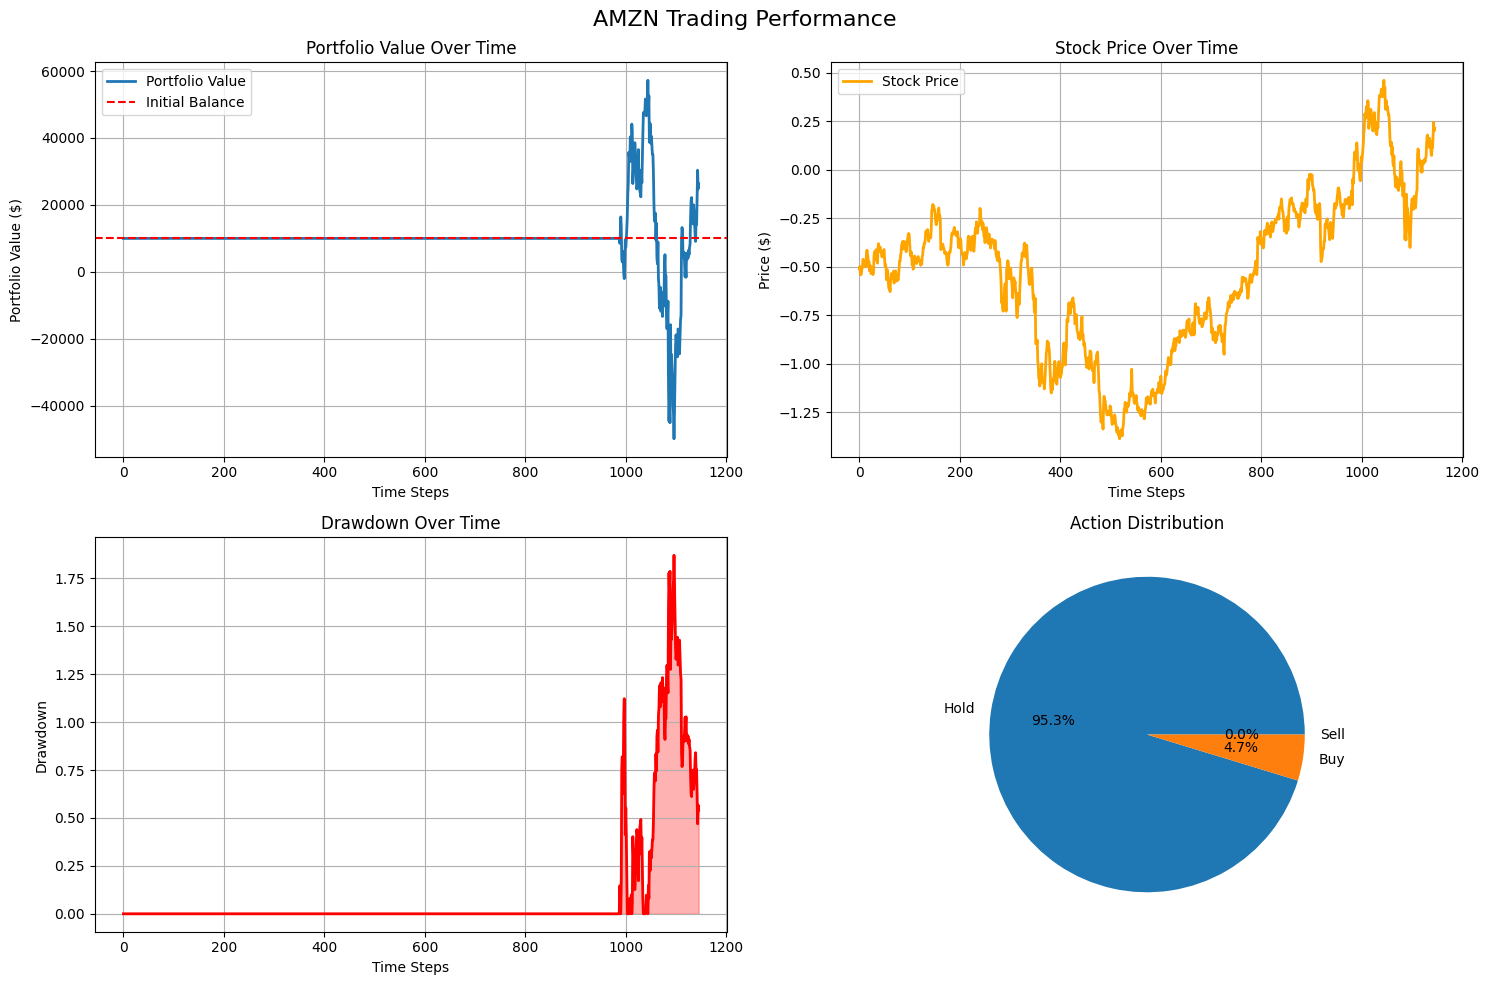

2025-07-04 17:14:35 - trainer_MyTestExp - INFO - 📊 AMZN - Return: 162.87%, Sharpe: 0.74
2025-07-04 17:14:35 - trainer_MyTestExp - INFO - Evaluating MSFT: |████████████░░░░░░░░░░░░░░░░░░| 40.0% (2/5)


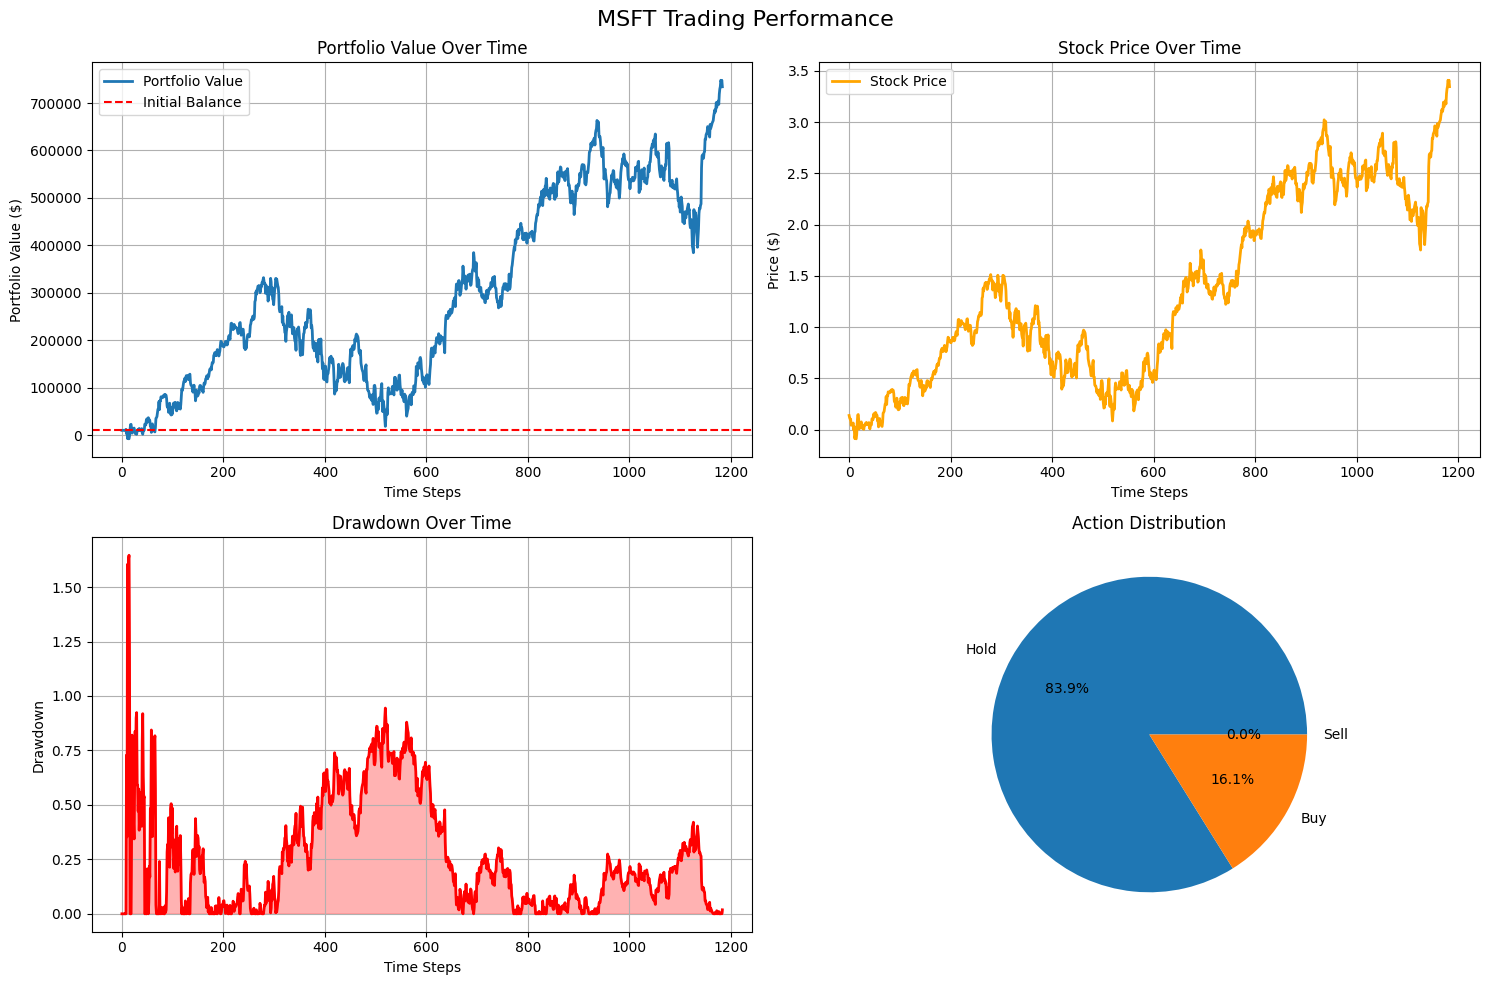

2025-07-04 17:14:37 - trainer_MyTestExp - INFO - 📊 MSFT - Return: 7243.44%, Sharpe: 0.56
2025-07-04 17:14:37 - trainer_MyTestExp - INFO - Evaluating GOOGL: |██████████████████░░░░░░░░░░░░| 60.0% (3/5)


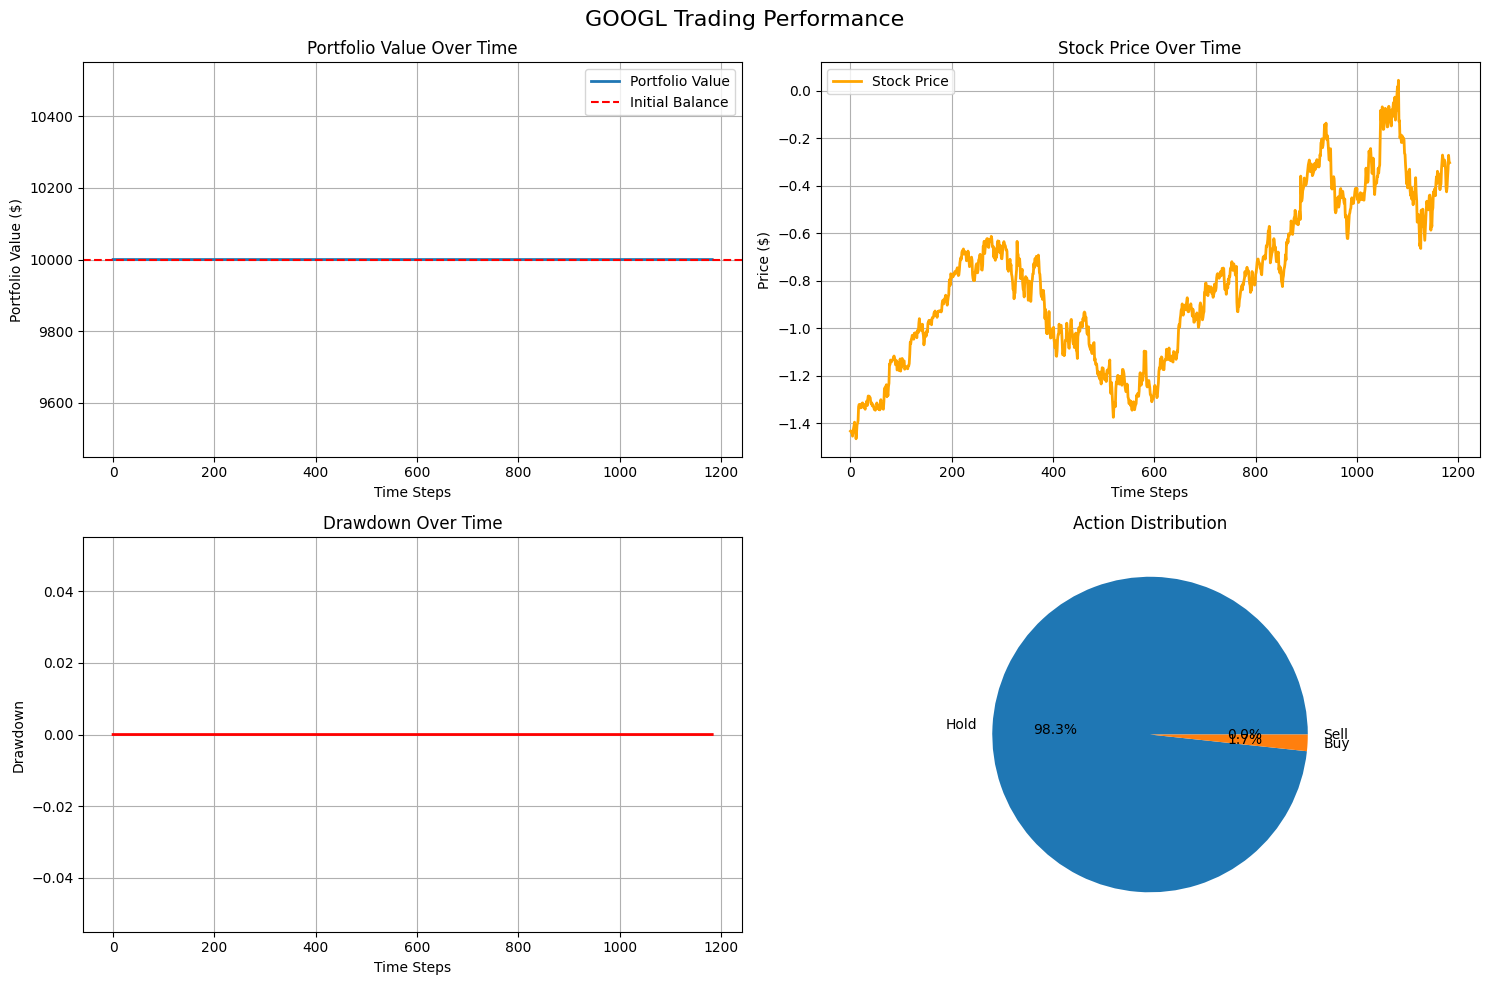

2025-07-04 17:14:40 - trainer_MyTestExp - INFO - 📊 GOOGL - Return: 0.00%, Sharpe: 0.00
2025-07-04 17:14:40 - trainer_MyTestExp - INFO - Evaluating TSLA: |████████████████████████░░░░░░| 80.0% (4/5)


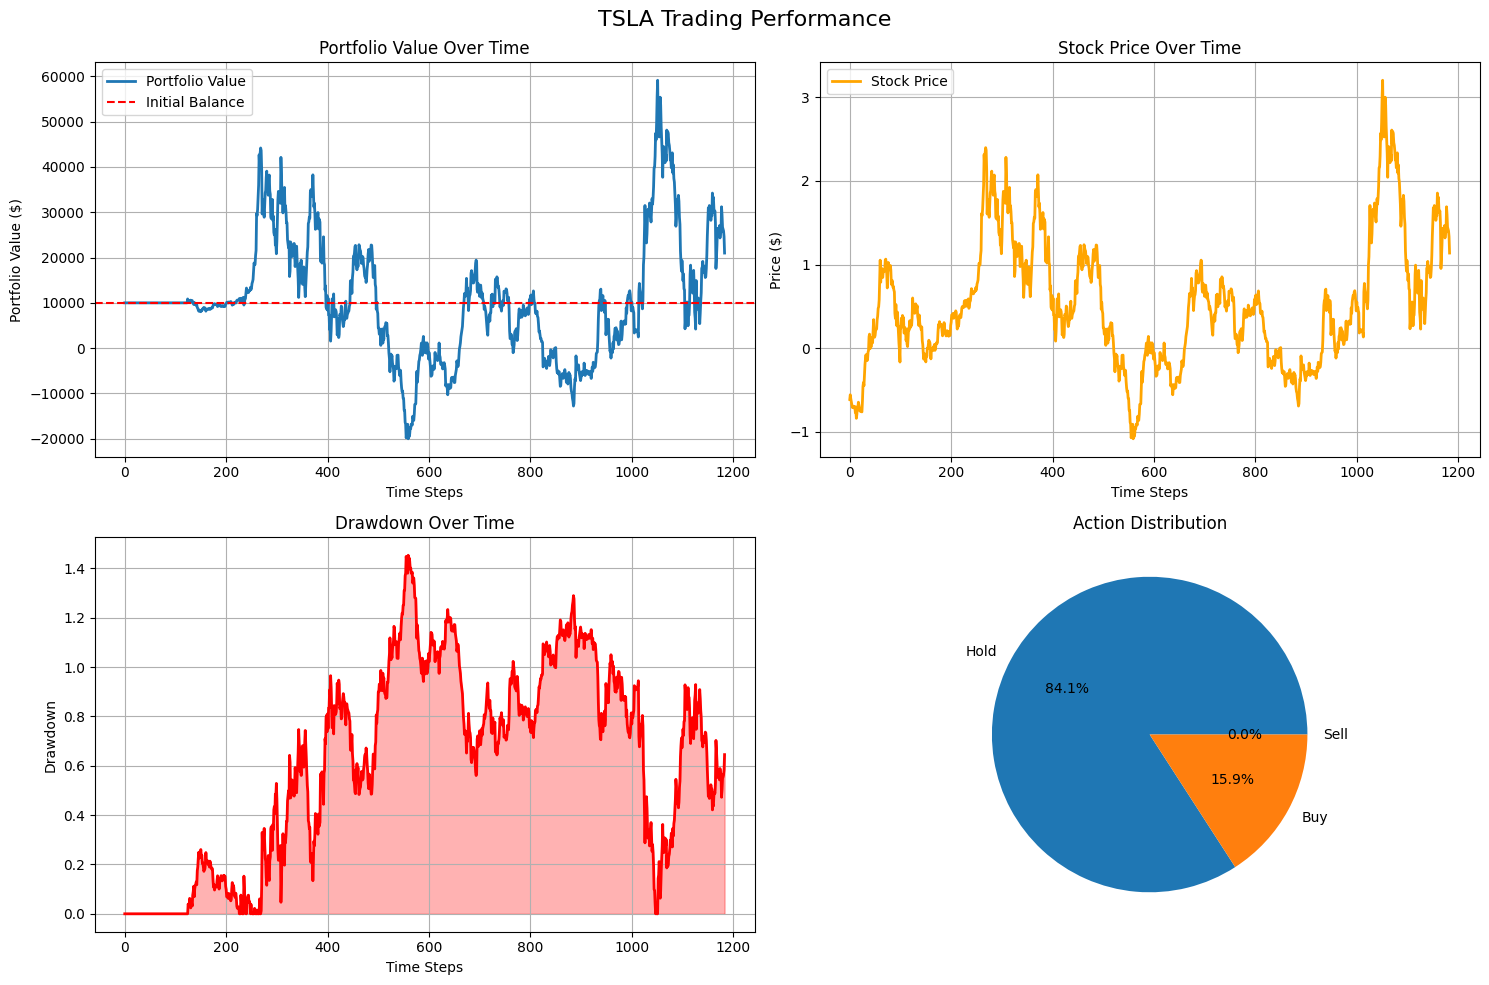

2025-07-04 17:14:43 - trainer_MyTestExp - INFO - 📊 TSLA - Return: 109.91%, Sharpe: -0.22
2025-07-04 17:14:43 - trainer_MyTestExp - INFO - Evaluating AAPL: |██████████████████████████████| 100.0% (5/5)


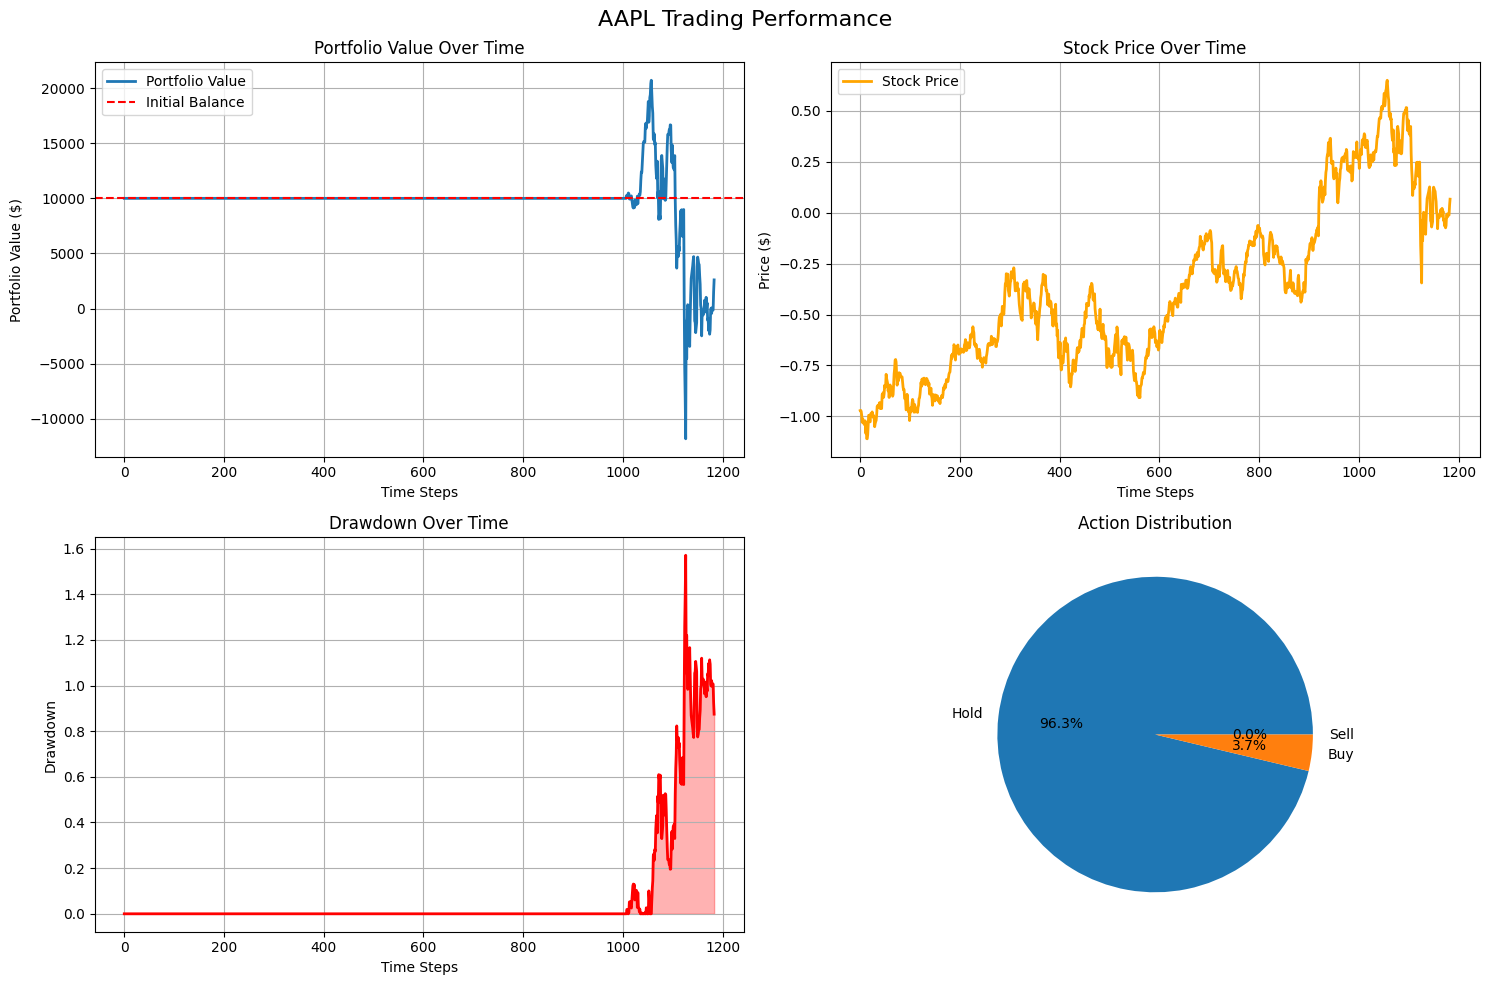

2025-07-04 17:14:46 - trainer_MyTestExp - INFO - 📊 AAPL - Return: -74.02%, Sharpe: 0.65
2025-07-04 17:14:46 - trainer_MyTestExp - INFO - 💾 Evaluation results saved to experiments/MyTestExp/models/evaluation_results.json
2025-07-04 17:14:46 - trainer_MyTestExp - INFO - ⏱️  Model Evaluation completed in 0:00:14.070563
2025-07-04 17:14:46 - resumer_MyTestExp - INFO - ☁️  Uploading to HuggingFace Hub...
2025-07-04 17:14:46 - hf_uploader_MyTestExp - INFO - ✅ Authenticated as: Adilbai
2025-07-04 17:14:46 - hf_uploader_MyTestExp - INFO - 🆕 Creating new repository: Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:46 - hf_uploader_MyTestExp - INFO - ✅ Repository created: https://huggingface.co/Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:46 - hf_uploader_MyTestExp - INFO - 📤 Starting upload to Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:47 - hf_uploader_MyTestExp - INFO - ✅ Model card uploaded
2025-07-04 17:14:47 - hf_uploader_MyTestExp - INFO - 📤 Uploading f

Uploading...:   0%|          | 0.00/4.88M [00:00<?, ?B/s]

2025-07-04 17:14:49 - hf_uploader_MyTestExp - INFO - ✅ final_model uploaded
2025-07-04 17:14:49 - hf_uploader_MyTestExp - INFO - 📤 Uploading evaluation_results...
2025-07-04 17:14:49 - hf_uploader_MyTestExp - INFO - ✅ evaluation_results uploaded
2025-07-04 17:14:49 - hf_uploader_MyTestExp - INFO - 📤 Uploading scaler...


Uploading...:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

2025-07-04 17:14:51 - hf_uploader_MyTestExp - INFO - ✅ scaler uploaded
2025-07-04 17:14:51 - hf_uploader_MyTestExp - INFO - 📤 Uploading processed_data...


Uploading...:   0%|          | 0.00/145M [00:00<?, ?B/s]

2025-07-04 17:14:54 - hf_uploader_MyTestExp - INFO - ✅ processed_data uploaded
2025-07-04 17:14:54 - hf_uploader_MyTestExp - INFO - 📤 Uploading config...
2025-07-04 17:14:54 - hf_uploader_MyTestExp - INFO - ✅ config uploaded
2025-07-04 17:14:54 - hf_uploader_MyTestExp - INFO - 🎉 Upload completed! 5 files uploaded to Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:54 - hf_uploader_MyTestExp - INFO - 🔗 View at: https://huggingface.co/Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:54 - resumer_MyTestExp - INFO - ✅ Model uploaded to: https://huggingface.co/Adilbai/stock-trading-rl-20250704-171446
2025-07-04 17:14:54 - resumer_MyTestExp - INFO - ✅ Pipeline resumed and completed successfully!


In [20]:
import os
import json
import pickle
from pathlib import Path
from datetime import datetime
from typing import Dict, Optional, Any
import argparse

class PipelineResumer:
    """Resume pipeline from specific steps"""
    
    def __init__(self, experiment_dir: str):
        self.experiment_dir = Path(experiment_dir)
        self.experiment_name = self.experiment_dir.name
        
        # Setup logger
        self.logger = EnhancedLogger(
            name=f"resumer_{self.experiment_name}",
            log_dir=str(self.experiment_dir / "logs"),
            level="INFO"
        )
        
        # Validate experiment directory
        if not self.experiment_dir.exists():
            raise ValueError(f"Experiment directory not found: {experiment_dir}")
        
        self.logger.info(f"🔄 Resuming pipeline for experiment: {self.experiment_name}")
        self.logger.info(f"📁 Experiment directory: {self.experiment_dir}")
    
    def load_trainer_state(self) -> ModularStockTrainer:
        """Load trainer with existing data and models"""
        self.logger.info("📦 Loading trainer state...")
        
        # Load config
        config_path = self.experiment_dir / "config.json"
        if not config_path.exists():
            raise FileNotFoundError(f"Config file not found: {config_path}")
        
        # Create trainer
        trainer = ModularStockTrainer(
            config_path=str(config_path),
            experiment_name=self.experiment_name,
            log_level="INFO"
        )
        
        # Load existing data
        self._load_existing_data(trainer)
        
        # Load models if they exist
        self._load_existing_models(trainer)
        
        self.logger.info("✅ Trainer state loaded successfully")
        return trainer
    
    def _load_existing_data(self, trainer: ModularStockTrainer):
        """Load existing processed data"""
        data_dir = self.experiment_dir / "data"
        
        # Load RL data
        rl_data_path = data_dir / "processed_stock_data_rl_20250704_164107.pkl"
        if rl_data_path.exists():
            with open(rl_data_path, 'rb') as f:
                trainer.rl_data = pickle.load(f)
            self.logger.info(f"📊 Loaded RL data for {len(trainer.rl_data)} stocks")
        else:
            self.logger.warning("⚠️  No RL data found, will need to process fresh data")
        
        # Load scaler
        scaler_path = data_dir / "processed_stock_data_scaler_20250704_164107.pkl"
        if scaler_path.exists():
            with open(scaler_path, 'rb') as f:
                trainer.scaler = pickle.load(f)
            self.logger.info("📐 Loaded data scaler")
        
        # Load raw data if available
        raw_data_path = data_dir / "raw_data.csv"
        if raw_data_path.exists():
            import pandas as pd
            trainer.raw_data = pd.read_csv(raw_data_path)
            self.logger.info("📈 Loaded raw data")
    
    def _load_existing_models(self, trainer: ModularStockTrainer):
        """Load existing trained models"""
        models_dir = self.experiment_dir / "models"
        
        # Check for best model
        best_model_path = models_dir / "best_model.zip"
        final_model_path = models_dir / "final_model.zip"
        
        if best_model_path.exists():
            self.logger.info("🏆 Found best model")
        elif final_model_path.exists():
            self.logger.info("🎯 Found final model")
        else:
            self.logger.warning("⚠️  No trained models found")
    
    def resume_from_evaluation(self, 
                              upload_to_hf: bool = True,
                              hf_repo_name: Optional[str] = None,
                              private_repo: bool = False):
        """Resume pipeline from evaluation step"""
        self.logger.info("🔄 Resuming from evaluation step...")
        
        try:
            # Load trainer state
            trainer = self.load_trainer_state()
            
            # If no data loaded, prepare fresh data
            if not trainer.rl_data:
                self.logger.info("📊 No existing data found, preparing fresh data...")
                trainer.prepare_data()
            
            # Create environments for evaluation
            self.logger.info("🏪 Creating evaluation environments...")
            trainer.create_environments()
            
            # Run evaluation
            self.logger.info("🔍 Running evaluation...")
            model_path = self.experiment_dir / "models" / "final_model.zip"
            evaluation_results = trainer.evaluate(str(model_path))

            
            # Upload to HuggingFace if requested
            if upload_to_hf:
                self.logger.info("☁️  Uploading to HuggingFace Hub...")
                self._upload_to_huggingface(trainer, hf_repo_name, private_repo)
            
            self.logger.info("✅ Pipeline resumed and completed successfully!")
            return evaluation_results
            
        except Exception as e:
            self.logger.error(f"❌ Resume failed: {e}")
            raise
    
    def resume_from_training(self,
                            upload_to_hf: bool = True,
                            hf_repo_name: Optional[str] = None,
                            private_repo: bool = False):
        """Resume pipeline from training step (if models don't exist)"""
        self.logger.info("🔄 Resuming from training step...")
        
        try:
            # Load trainer state
            trainer = self.load_trainer_state()
            
            # If no data loaded, prepare fresh data
            if not trainer.rl_data:
                self.logger.info("📊 Preparing fresh data...")
                trainer.prepare_data()
            
            # Create environments
            self.logger.info("🏪 Creating environments...")
            trainer.create_environments()
            
            # Create model
            self.logger.info("🤖 Creating model...")
            trainer.create_model()
            
            # Train model
            self.logger.info("🚀 Starting training...")
            trainer.train()
            
            # Evaluate model
            self.logger.info("🔍 Running evaluation...")
            evaluation_results = trainer.evaluate()
            
            # Upload to HuggingFace if requested
            if upload_to_hf:
                self.logger.info("☁️  Uploading to HuggingFace Hub...")
                self._upload_to_huggingface(trainer, hf_repo_name, private_repo)
            
            self.logger.info("✅ Pipeline resumed and completed successfully!")
            return evaluation_results
            
        except Exception as e:
            self.logger.error(f"❌ Resume failed: {e}")
            raise
    
    def _upload_to_huggingface(self, 
                              trainer: ModularStockTrainer,
                              hf_repo_name: Optional[str] = None,
                              private_repo: bool = False):
        """Upload to HuggingFace Hub"""
        try:
            uploader = HuggingFaceUploader(
                username="Adilbai",
                experiment_name=self.experiment_name
            )
            
            repo_id = uploader.upload_experiment(
                experiment_dir=str(self.experiment_dir),
                repo_name=hf_repo_name or f"stock-trading-rl-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
                private=private_repo,
                description=f"Stock trading RL model - {self.experiment_name}"
            )
            
            if repo_id:
                self.logger.info(f"✅ Model uploaded to: https://huggingface.co/{repo_id}")
                return repo_id
            else:
                self.logger.error("❌ Upload failed")
                return None
                
        except Exception as e:
            self.logger.error(f"❌ HuggingFace upload failed: {e}")
            return None
    
    def just_evaluate(self, model_name: str = "best_model"):
        """Just run evaluation on existing model"""
        self.logger.info(f"🔍 Running evaluation only with {model_name}...")
        
        try:
            # Load trainer state
            trainer = self.load_trainer_state()
            
            # If no data loaded, prepare fresh data
            if not trainer.rl_data:
                self.logger.info("📊 Preparing fresh data for evaluation...")
                trainer.prepare_data()
            
            # Create environments for evaluation
            trainer.create_environments()
            
            # Find model path
            model_path = self.experiment_dir / "models" / f"{model_name}.zip"
            if not model_path.exists():
                raise FileNotFoundError(f"Model not found: {model_path}")
            
            # Run evaluation
            evaluation_results = trainer.evaluate(str(model_path))
            
            self.logger.info("✅ Evaluation completed!")
            return evaluation_results
            
        except Exception as e:
            self.logger.error(f"❌ Evaluation failed: {e}")
            raise
    
    def just_upload(self, 
                   hf_repo_name: Optional[str] = None,
                   private_repo: bool = False):
        """Just upload to HuggingFace Hub"""
        self.logger.info("☁️  Uploading to HuggingFace Hub only...")
        
        try:
            uploader = HuggingFaceUploader(
                username="AdilzhanB",
                experiment_name=self.experiment_name
            )
            
            repo_id = uploader.upload_experiment(
                experiment_dir=str(self.experiment_dir),
                repo_name=hf_repo_name or f"stock-trading-rl-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
                private=private_repo,
                description=f"Stock trading RL model - {self.experiment_name}"
            )
            
            if repo_id:
                self.logger.info(f"✅ Model uploaded to: https://huggingface.co/{repo_id}")
                return repo_id
            else:
                self.logger.error("❌ Upload failed")
                return None
                
        except Exception as e:
            self.logger.error(f"❌ Upload failed: {e}")
            return None
    
    def list_available_models(self):
        """List available models in the experiment"""
        models_dir = self.experiment_dir / "models"
        
        if not models_dir.exists():
            self.logger.info("📂 No models directory found")
            return []
        
        models = []
        for model_file in models_dir.glob("*.zip"):
            models.append(model_file.stem)
        
        self.logger.info(f"📦 Available models: {models}")
        return models
    
    def get_experiment_status(self):
        """Get current experiment status"""
        status = {
            "experiment_name": self.experiment_name,
            "experiment_dir": str(self.experiment_dir),
            "has_config": (self.experiment_dir / "config.json").exists(),
            "has_data": (self.experiment_dir / "data" / "rl_data.pkl").exists(),
            "has_models": len(list((self.experiment_dir / "models").glob("*.zip"))) > 0 if (self.experiment_dir / "models").exists() else False,
            "has_evaluation": (self.experiment_dir / "models" / "evaluation_results.json").exists(),
            "available_models": self.list_available_models()
        }
        
        self.logger.info("📊 Experiment Status:")
        for key, value in status.items():
            self.logger.info(f"  {key}: {value}")
        
        return status

def main(argv=None):
    """Command line interface for resuming pipeline"""
    parser = argparse.ArgumentParser(description="Resume training pipeline from specific steps")
    
    parser.add_argument(
        "experiment_dir",
        help="Path to experiment directory"
    )
    
    parser.add_argument(
        "--action",
        choices=["eval", "train", "upload", "eval-upload", "train-eval-upload", "status"],
        default="eval-upload",
        help="Action to perform"
    )
    
    parser.add_argument(
        "--model",
        default="best_model",
        help="Model to use for evaluation"
    )
    
    parser.add_argument(
        "--repo-name",
        help="HuggingFace repository name"
    )
    
    parser.add_argument(
        "--private",
        action="store_true",
        help="Make HuggingFace repository private"
    )
    
    parser.add_argument(
        "--no-upload",
        action="store_true",
        help="Skip HuggingFace upload"
    )
    
    args = parser.parse_args(argv)
    
    # Create resumer
    resumer = PipelineResumer(args.experiment_dir)
    
    # Execute action
    if args.action == "status":
        resumer.get_experiment_status()
    
    elif args.action == "eval":
        resumer.just_evaluate(args.model)
    
    elif args.action == "upload":
        resumer.just_upload(args.repo_name, args.private)
    
    elif args.action == "eval-upload":
        resumer.resume_from_evaluation(
            upload_to_hf=not args.no_upload,
            hf_repo_name=args.repo_name,
            private_repo=args.private
        )
    
    elif args.action == "train":
        resumer.resume_from_training(
            upload_to_hf=False
        )
    
    elif args.action == "train-eval-upload":
        resumer.resume_from_training(
            upload_to_hf=not args.no_upload,
            hf_repo_name=args.repo_name,
            private_repo=args.private
        )

if __name__ == "__main__":
    main(['experiments/MyTestExp', '--action', 'eval-upload'])

In [ ]:
from huggingface_hub import upload_folder
upload_folder()